In [ ]:
 #Step 1: Install Required Packages

!pip install langchain openai chromadb transformers pypdf sentence-transformers accelerate
!pip install -U sentence-transformers langchain-huggingface chromadb
#!pip -q install -U bitsandbytes transformers accelerate peft safetensors
!pip -q install -U bitsandbytes peft safetensors
!pip install -U langchain-huggingface
!pip install unstructured faiss-cpu
!pip install -U langchain-community
!pip install PyMuPDF
!pip install evaluate
!pip install rouge_score
!pip install pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 18.8 MB/s et

In [ ]:
#Step 2: Load PDF Files from Google Drive

import warnings
warnings.filterwarnings('ignore')

import os
from langchain.document_loaders import PyPDFLoader
from google.colab import drive

# 🔗 Mount Google Drive
drive.mount('/content/drive')

def load_pdfs_from_gdrive(folder_path):
    documents = []
    print("📄 Loaded PDF Files and Page Counts:")
    print("------------------------------------")

    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            try:
                loader = PyPDFLoader(file_path)
                file_docs = loader.load()
                num_pages = len(file_docs)
                print(f"File: {filename}, Pages: {num_pages}")
                documents.extend(file_docs)
            except Exception as e:
                print(f"❌ Failed to load {filename}: {e}")

    print("------------------------------------")
    print(f"✅ Total documents loaded: {len(documents)}")
    return documents

# Example usage
gdrive_path = "/content/drive/MyDrive/Master Thesis/Datasets/Commercial_Insurance_Policy_Wordings_Clauses/"
docs = load_pdfs_from_gdrive(gdrive_path)


Mounted at /content/drive
📄 Loaded PDF Files and Page Counts:
------------------------------------


File: CGL_Coverage Form.pdf, Pages: 70
File: BOP_Coverage Form_from Chubb.pdf, Pages: 160
File: General ISO Businessowners Overview_from Verisk_2025.pdf, Pages: 22
File: CISR-Commercial-Property.pdf, Pages: 173
------------------------------------
✅ Total documents loaded: 425


In [ ]:
#Step 3: Chunk Documents (Recursive with overlap)

from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunk_documents(documents, chunk_size=500, chunk_overlap=50):
    #splitter = RecursiveCharacterTextSplitter(
        #chunk_size=chunk_size,
        #chunk_overlap=chunk_overlap,
        #add_start_index=True,
    #)

    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        add_start_index=True,
    )
    return splitter.split_documents(documents)

# Configurable chunking
chunked_docs = chunk_documents(docs, chunk_size=1000, chunk_overlap=50)
print(f"✅ Step 2 Complete: Chunked {len(docs)} documents into {len(chunked_docs)} chunks.")


✅ Step 2 Complete: Chunked 425 documents into 514 chunks.


In [ ]:
# Step 3: Chunk Documents (Semantic-only)

!pip install -qU langchain-experimental langchain-huggingface

from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface import HuggingFaceEmbeddings  # Can be swapped for OpenAIEmbeddings, etc.

def chunk_documents_semantic(
    documents,
    embedding_model_name="llmware/industry-bert-insurance-v0.1",   # or any HF model you prefer
    breakpoint_threshold_type="percentile",                 # "percentile" | "standard_deviation" | "interquartile" | "gradient"
    breakpoint_threshold_amount=95.0,                       # higher => fewer, larger chunks
    min_chunk_size=None,                                    # optional char floor for tiny chunks (e.g., 200)
    number_of_chunks=None,                                  # optional: target a fixed number of chunks
    add_start_index=True,
    buffer_size=1                                           # sentences grouped before similarity check
):
    # Embeddings are used only to measure semantic similarity for split points (no storage here).
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

    splitter = SemanticChunker(
        embeddings=embeddings,
        buffer_size=buffer_size,
        add_start_index=add_start_index,
        breakpoint_threshold_type=breakpoint_threshold_type,
        breakpoint_threshold_amount=breakpoint_threshold_amount,
        number_of_chunks=number_of_chunks,
        min_chunk_size=min_chunk_size,
    )
    return splitter.split_documents(documents)

# Usage
chunked_docs = chunk_documents_semantic(docs)
print(f"✅ Step 2 Complete: Chunked {len(docs)} docs into {len(chunked_docs)} semantic chunks.")


config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Step 2 Complete: Chunked 425 docs into 966 semantic chunks.


In [ ]:
# Step 3: Document-based Chunking (layout-aware: tables + two-column)
# If needed in Colab:
!pip install -qU "langchain-community>=0.2.6" "unstructured[pdf]" tiktoken

from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

def chunk_documents_layout_aware(
    docs,
    token_chunk_size: int = 400,
    token_overlap: int = 100,
    keep_tables_single: bool = True,
):
    """
    Takes pages loaded via PyPDFLoader (docs), re-parses each *file* with Unstructured
    to retain table structure and proper reading order, then token-splits text elements.
    Returns a flat list[Document] with metadata: source, page_number, type, etc.
    """
    # Unique PDF file paths from your existing docs
    file_paths = sorted({d.metadata.get("source") for d in docs if d.metadata.get("source")})

    # Token-based limiter for final chunk sizes (no embeddings here)
    size_limiter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        chunk_size=token_chunk_size,
        chunk_overlap=token_overlap,
        add_start_index=True,
    )

    out_chunks = []
    for path in file_paths:
        # layout-aware parse; fallback to "fast" if hi_res deps aren’t available
        try:
            loader = UnstructuredPDFLoader(
                path,
                mode="elements",
                strategy="hi_res",
                infer_table_structure=True,
            )
            elements = loader.load()
        except Exception:
            loader = UnstructuredPDFLoader(
                path,
                mode="elements",
                strategy="fast",
                infer_table_structure=True,
            )
            elements = loader.load()

        for el in elements:
            etype = (el.metadata.get("category") or el.metadata.get("type") or "").lower()
            # Keep tables intact as one chunk (optional)
            if "table" in etype and keep_tables_single:
                el.metadata.update({"type": "table", "source": path})
                out_chunks.append(el)
                continue

            # Split narrative / title / list / etc. into token-bounded chunks
            for piece in size_limiter.split_text(el.page_content or ""):
                md = dict(el.metadata)
                md.update({"type": "text", "source": path})
                out_chunks.append(Document(page_content=piece, metadata=md))

    return out_chunks


chunked_docs = chunk_documents_layout_aware(docs, token_chunk_size=1000, token_overlap=100)
print(f"✅ Step 2 Complete: {len(chunked_docs)} layout-aware chunks produced from {len(docs)} input pages.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 99.7 MB/s eta 0:00:00


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

✅ Step 2 Complete: 7007 layout-aware chunks produced from 425 input pages.


In [ ]:
# Step 4: Get a view of the chunks in a tabular format showing which page number and document each chunk belongs to.

import os
import pandas as pd

# Build a table of Document Name, Page #, Chunk Text
rows = []
for doc in chunked_docs:
    m = getattr(doc, "metadata", {}) or {}

    # document name (best-effort from metadata)
    src = m.get("source") or m.get("file_path") or ""
    doc_name = os.path.basename(src) if src else "unknown"

    # page number (convert 0-based to 1-based if present)
    page = m.get("page", m.get("page_number"))
    if isinstance(page, int):
        page = page + 1

    rows.append({
        "Document Name": doc_name,
        "Page No.": page,
        "Chunk Text": getattr(doc, "page_content", ""),
    })

df = pd.DataFrame(rows, columns=["Document Name", "Page No.", "Chunk Text"])

# Display (full text in cells)
pd.set_option("display.max_colwidth", None)
from IPython.display import display
display(df.head(5))     # preview first 5 rows

,Document Name,Page No.,Chunk Text
0,BOP_Coverage Form_from Chubb.pdf,2,BUSINESSOWNERS BP 00 03 07 13
1,BOP_Coverage Form_from Chubb.pdf,2,BUSINESSOWNERS COVERAGE FORM
2,BOP_Coverage Form_from Chubb.pdf,2,"Various provisions in this policy restrict coverage. Read the entire policy carefully to determine rights, duties and what is and is not covered."
3,BOP_Coverage Form_from Chubb.pdf,2,"(5) Personal property owned by you that is used to maintain or service the buildings or structures or the premises, including:"
4,BOP_Coverage Form_from Chubb.pdf,2,"Throughout this Coverage Form, the words ""you"" and ""your"" refer to the Named Insured shown in the Declarations. The words ""we"", ""us"" and ""our"" refer to the company providing this insurance."


In [ ]:
# Show the number of chunks after applying chunking strategy

print(f"Number of chunks: {len(df)}")


Number of chunks: 7007


In [ ]:
# Step 5: Check the length of all the texts as there might be some empty pages or pages with very few words that can be dropped

df['Text_Length'] = df['Chunk Text'].apply(lambda x: len(x.split(' ')))
df

,Document Name,Page No.,Chunk Text,Text_Length
0,BOP_Coverage Form_from Chubb.pdf,2,BUSINESSOWNERS BP 00 03 07 13,6
1,BOP_Coverage Form_from Chubb.pdf,2,BUSINESSOWNERS COVERAGE FORM,3
2,BOP_Coverage Form_from Chubb.pdf,2,"Various provisions in this policy restrict coverage. Read the entire policy carefully to determine rights, duties and what is and is not covered.",23
3,BOP_Coverage Form_from Chubb.pdf,2,"(5) Personal property owned by you that is used to maintain or service the buildings or structures or the premises, including:",21
4,BOP_Coverage Form_from Chubb.pdf,2,"Throughout this Coverage Form, the words ""you"" and ""your"" refer to the Named Insured shown in the Declarations. The words ""we"", ""us"" and ""our"" refer to the company providing this insurance.",31
...,...,...,...,...
7002,CGL_Coverage Form.pdf,71,!,1
7003,CGL_Coverage Form.pdf,71,"!""#$%&#'()""*+,&-.$/0(1%$/,&%2(""3(4%$&""#%2(5''"")&%$&""#(""3(6#'7,%#)/(!""11&''&""#/,'( 8&$.(&$'(*/,1&''&""#9( (",3
7004,CGL_Coverage Form.pdf,71,"!+,-$)$./$)$",1
7005,CGL_Coverage Form.pdf,71,!,1


In [ ]:
# Step 6: Embed & Store in Vector DB (Embedding Model - llmware/industry-bert-insurance-v0.1)

from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import filter_complex_metadata # Import the filtering utility

def create_vectorstore(
    documents,
    embedding_model_name="llmware/industry-bert-insurance-v0.1",
    persist_dir="./vector_db"
):
    # pick device if torch is available; otherwise default to CPU
    try:
        import torch
        device = "cuda" if torch.cuda.is_available() else "cpu"
    except Exception:
        device = "cpu"

    embedding = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs={"device": device},
        # normalize for cosine similarity in most vector DBs, including Chroma
        encode_kwargs={"normalize_embeddings": True}
    )

    # Filter out complex metadata
    documents = filter_complex_metadata(documents)

    vectordb = Chroma.from_documents(
        documents,
        embedding=embedding,
        persist_directory=persist_dir
    )
    vectordb.persist()

    print(" Step 3 Complete:")
    print(f"🔹 Number of embedded chunks: {len(documents)}")
    print(f"🔹 Embedding model used: {embedding_model_name}")
    print(f"🔹 Vector DB stored at: {persist_dir}")

    return vectordb

# Example usage
vectordb = create_vectorstore(chunked_docs)

# Inspect first 3 vectors stored in Chroma (IDs + embedding preview)
import pandas as pd

res = vectordb._collection.get(limit=3, include=["embeddings", "documents"])
ids = res["ids"]
embs = res["embeddings"]
docs = res["documents"]

rows = []
for id_, vec, doc in zip(ids, embs, docs):
    # first 8 dims as a compact string
    preview = ", ".join(f"{float(v):.4f}" for v in vec[:8])
    rows.append({
        "ID": id_,
        "Embedding (dim)": len(vec),
        "Embedding (first 4 dims)": preview,
        "Doc preview": doc[:200] + ("..." if len(doc) > 200 else "")
    })

df2 = pd.DataFrame(rows, columns=["ID", "Embedding (dim)", "Embedding (first 4 dims)", "Doc preview"])

# Display in notebooks
pd.set_option("display.max_colwidth", None)
from IPython.display import display
display(df2)

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

 Step 3 Complete:
🔹 Number of embedded chunks: 7007
🔹 Embedding model used: llmware/industry-bert-insurance-v0.1
🔹 Vector DB stored at: ./vector_db


/tmp/ipython-input-1164880577.py:34: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


,ID,Embedding (dim),Embedding (first 4 dims),Doc preview
0,a22c7556-d65c-4d04-ad6e-d2fd77efc24d,768,"0.0091, 0.0656, 0.0363, -0.0243, 0.0257, 0.0130, -0.0294, -0.0467",BUSINESSOWNERS BP 00 03 07 13
1,9ee68fc9-690b-4f69-a2fe-0d11902aa7fd,768,"0.0434, 0.0293, 0.0595, -0.0741, 0.0638, -0.0067, 0.0063, -0.0818",BUSINESSOWNERS COVERAGE FORM
2,1508125d-a43f-4f22-8d9f-445672ecd207,768,"0.0367, -0.0282, -0.0410, -0.0206, 0.0398, -0.0295, -0.0460, -0.0233","Various provisions in this policy restrict coverage. Read the entire policy carefully to determine rights, duties and what is and is not covered."


In [ ]:
# Step 6: Embed & Store in Vector DB (Embedding Model - llmware/industry-bert-insurance-v0.1)

from langchain.vectorstores import Chroma
# from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

#!pip install -U sentence-transformers langchain-huggingface chromadb

def create_vectorstore(
    documents,
    embedding_model_name="llmware/industry-bert-insurance-v0.1",
    persist_dir="./vector_db"
):
    # pick device if torch is available; otherwise default to CPU
    try:
        import torch
        device = "cuda" if torch.cuda.is_available() else "cpu"
    except Exception:
        device = "cpu"

    embedding = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs={"device": device},
        # normalize for cosine similarity in most vector DBs, including Chroma
        encode_kwargs={"normalize_embeddings": True}
    )

    vectordb = Chroma.from_documents(
        documents,
        embedding=embedding,
        persist_directory=persist_dir
    )
    vectordb.persist()

    print(" Step 3 Complete:")
    print(f"🔹 Number of embedded chunks: {len(documents)}")
    print(f"🔹 Embedding model used: {embedding_model_name}")
    print(f"🔹 Vector DB stored at: {persist_dir}")

    return vectordb

# Example usage
vectordb = create_vectorstore(chunked_docs)

# Inspect first 3 vectors stored in Chroma (IDs + embedding preview)
import pandas as pd

res = vectordb._collection.get(limit=3, include=["embeddings", "documents"])
ids = res["ids"]
embs = res["embeddings"]
docs = res["documents"]

rows = []
for id_, vec, doc in zip(ids, embs, docs):
    # first 8 dims as a compact string
    preview = ", ".join(f"{float(v):.4f}" for v in vec[:8])
    rows.append({
        "ID": id_,
        "Embedding (dim)": len(vec),
        "Embedding (first 4 dims)": preview,
        "Doc preview": doc[:200] + ("..." if len(doc) > 200 else "")
    })

df2 = pd.DataFrame(rows, columns=["ID", "Embedding (dim)", "Embedding (first 4 dims)", "Doc preview"])

# Display in notebooks
pd.set_option("display.max_colwidth", None)
from IPython.display import display
display(df2)

In [ ]:
#Step 6: Embed & Store in Vector DB (Alternative Embedding Model - "sentence-transformers/all-MiniLM-L6-v2")

from langchain.vectorstores import Chroma
#from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

def create_vectorstore(documents, embedding_model_name="sentence-transformers/all-MiniLM-L6-v2", persist_dir="./vector_db"):
    embedding = HuggingFaceEmbeddings(model_name=embedding_model_name)
    vectordb = Chroma.from_documents(documents, embedding=embedding, persist_directory=persist_dir)
    vectordb.persist()


    print(" Step 3 Complete:")
    print(f"🔹 Number of embedded chunks: {len(documents)}")
    print(f"🔹 Embedding model used: {embedding_model_name}")
    print(f"🔹 Vector DB stored at: {persist_dir}")

    return vectordb

# Example usage
vectordb = create_vectorstore(chunked_docs)

# Inspect first 3 vectors stored in Chroma (IDs + embedding preview)
import pandas as pd

res = vectordb._collection.get(limit=3, include=["embeddings", "documents"])
ids = res["ids"]
embs = res["embeddings"]
docs = res["documents"]

rows = []
for id_, vec, doc in zip(ids, embs, docs):
    # first 8 dims as a compact string
    preview = ", ".join(f"{float(v):.4f}" for v in vec[:8])
    rows.append({
        "ID": id_,
        "Embedding (dim)": len(vec),
        "Embedding (first 4 dims)": preview,
        "Doc preview": doc[:200] + ("..." if len(doc) > 200 else "")
    })

df2 = pd.DataFrame(rows, columns=["ID", "Embedding (dim)", "Embedding (first 4 dims)", "Doc preview"])

# Display in notebooks
pd.set_option("display.max_colwidth", None)
from IPython.display import display
display(df2)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

ValueError: Expected metadata value to be a str, int, float, bool, or None, got {'points': ((456.48035400000003, 54.87430199999994), (456.48035400000003, 76.41429599999992), (552.6783660000001, 76.41429599999992), (552.6783660000001, 54.87430199999994)), 'system': 'PixelSpace', 'layout_width': 612.0, 'layout_height': 792.0} which is a dict in upsert.

Try filtering complex metadata from the document using langchain_community.vectorstores.utils.filter_complex_metadata.

In [ ]:
# Step 7: Evaluation of Retrieval metrics: Context Recall, MRR, nDCG@K
# Works with: list[Document] -> chunk -> embed once -> cosine top-K.
# Gold labels per QA: either "gold_spans": [str, ...] and/or "gold_pages": [int, ...]
# If a QA has no gold labels present in the corpus, that QA is skipped for recall/MRR/nDCG (not penalized).

from typing import List, Tuple, Dict
import numpy as np, pandas as pd, math
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
import torch
import os

def fast_eval_chunking_with_labels(
    raw_documents: List[Document],
    qa_pairs: List[Dict[str, object]],  # expects {"question": "...", "gold_spans":[...], "gold_pages":[...]} per item (spans/pages optional)
    strategies: List[Tuple[int, int]] = [(200,20), (400,40), (800,80)],
    embedding_model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
    k: int = 5,
    relevance_threshold: float = 0.40,    # used for context_precision only
    max_chunks_per_strategy: int = 4000,  # cap for speed
) -> pd.DataFrame:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embedder = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs={"device": device},
        encode_kwargs={"batch_size": 128, "normalize_embeddings": True},  # normalized => cosine == dot
    )

    def split_docs(cs, co):
        splitter = RecursiveCharacterTextSplitter(chunk_size=cs, chunk_overlap=co)
        return splitter.split_documents(raw_documents)

    def _norm_source(md: dict) -> str:
    # Try common keys; keep only the basename so matching is easy
        s = md.get("source") or md.get("file_path") or md.get("path") or md.get("filename") or ""
        return os.path.basename(str(s))

    def is_relevant(doc: Document, qa: dict) -> bool:
        """
        A chunk is relevant if (span match) OR (page matches), with optional document constraint.
        Supported gold labels on qa:
          - "gold_spans": [str, ...]
          - "gold_pages": [int, ...]                     # 0-based
          - "gold_sources" or "gold_docs": [str, ...]    # file names like "PolicyA.pdf"
          - "gold_page_refs": [{"source": "X.pdf","pages":[..]}, ...]  # precise per-doc pages
        """
        txt = (doc.page_content or "").lower()
        pg  = doc.metadata.get("page", None)
        src = _norm_source(doc.metadata)

        spans = [s.lower() for s in (qa.get("gold_spans") or [])]
        pages = qa.get("gold_pages") or []
        sources = qa.get("gold_sources") or qa.get("gold_docs") or []
        page_refs = qa.get("gold_page_refs") or []  # list of {"source": "...", "pages":[...]}

        # span match (no doc constraint unless gold_sources provided)
        span_ok = any(s in txt for s in spans) if spans else False

        # page match (optionally constrained to specific docs)
        page_ok = False
        if pages:
            if sources:
                page_ok = (pg in pages) and any(_norm_source({"source": ss}) == src or ss in src for ss in sources)
            else:
                page_ok = (pg in pages)

        # per-doc page refs (most precise)
        ref_ok = False
        if page_refs:
            for ref in page_refs:
                ref_src = _norm_source({"source": ref.get("source","")})
                ref_pages = ref.get("pages", [])
                if src == ref_src and pg in ref_pages:
                    ref_ok = True
                    break

        # If gold_sources provided without pages, require span match in that doc
        if sources and not pages and not page_refs:
            return span_ok and any(_norm_source({"source": ss}) == src or ss in src for ss in sources)

        return span_ok or page_ok or ref_ok

    def count_gold(chunks: list[Document], qa: dict) -> int:
    # how many chunks in the whole (chunked) corpus are labeled relevant by the same rules
        has_labels = bool(qa.get("gold_spans") or qa.get("gold_pages") or qa.get("gold_sources") or qa.get("gold_docs") or qa.get("gold_page_refs"))
        return sum(1 for d in chunks if is_relevant(d, qa)) if has_labels else 0

    def idcg_at_k(G: int, K: int) -> float:
        # binary gains; ideal DCG for G relevant items
        m = min(G, K)
        return sum(1.0 / math.log2(i + 2) for i in range(m))  # positions are 0-indexed here

    rows = []
    for cs, co in strategies:
        chunks = split_docs(cs, co)
        if max_chunks_per_strategy and len(chunks) > max_chunks_per_strategy:
            chunks = chunks[:max_chunks_per_strategy]

        texts = [d.page_content or "" for d in chunks]
        if not texts:
            rows.append({
                "chunk_size": cs, "chunk_overlap": co, "K": k, "relevance_threshold": relevance_threshold,
                "mean_context_precision": 0.0, "mean_context_relevance": 0.0,
                "mean_context_recall": 0.0, "mean_MRR": 0.0, "mean_nDCG": 0.0,
                "num_eval_queries": len(qa_pairs), "num_chunks": 0
            })
            continue

        chunk_embs = np.array(embedder.embed_documents(texts), dtype=np.float32)

        precisions, relevances = [], []
        recalls, mrrs, ndcgs = [], [], []

        for qa in qa_pairs:
            q = qa["question"]
            qv = np.array(embedder.embed_query(q), dtype=np.float32)
            sims = chunk_embs @ qv  # cosine

            # rank top-K
            if k < len(sims):
                idx = np.argpartition(sims, -k)[-k:]
                order = idx[np.argsort(sims[idx])[::-1]]
            else:
                order = np.argsort(sims)[::-1]

            topk = sims[order][:k]
            top_docs = [chunks[i] for i in order[:k]]

            topk01 = (topk + 1.0) / 2.0  # scale [-1,1] -> [0,1] (for readability/threshold)
            precisions.append(float(np.mean(topk01 >= relevance_threshold)))
            relevances.append(float(np.mean(topk01)))

            # labels for retrieval-quality metrics
            labels = [1 if is_relevant(d, qa) else 0 for d in top_docs]
            G = count_gold(chunks, qa)

            if G > 0:
                # Context Recall@K: proportion of gold items captured in top-K (binary labels)
                recalls.append(float(sum(labels) / min(G, k)))

                # MRR: reciprocal rank of first relevant
                if 1 in labels:
                    rank = labels.index(1) + 1  # 1-based
                    mrrs.append(1.0 / rank)
                else:
                    mrrs.append(0.0)

                # nDCG@K (binary relevance)
                dcg = sum(l / math.log2(i + 2) for i, l in enumerate(labels))
                idcg = idcg_at_k(G, k)
                ndcgs.append(float(dcg / idcg) if idcg > 0 else 0.0)
            # else: no gold labels found in corpus for this query ⇒ skip recall/MRR/nDCG

        def mean_or_zero(xs):
            return float(np.mean(xs)) if xs else 0.0

        rows.append({
            "chunk_size": cs,
            "chunk_overlap": co,
            "K": k,
            "relevance_threshold": relevance_threshold,
            "mean_context_precision": mean_or_zero(precisions),
            "mean_context_relevance": mean_or_zero(relevances),
            "mean_context_recall": mean_or_zero(recalls),
            "mean_MRR": mean_or_zero(mrrs),
            "mean_nDCG": mean_or_zero(ndcgs),
            "num_eval_queries": len(qa_pairs),
            "num_chunks": len(texts),
        })

    return pd.DataFrame(rows).sort_values(
        by=["mean_context_recall", "mean_MRR", "mean_nDCG"],
        ascending=[False, False, False]
    ).reset_index(drop=True)


# Example A: page-based labels (use your real page indices)
#qa_pairs = [
#    {"question": "What is covered under the Businessowners policy?", "gold_pages": [1, 2, 3]},
#    {"question": "What is covered under the Commercial General Liability policy?", "gold_pages": [1, 6, 8]},
#    {"question": "What perils are excluded in the commercial package policy?", "gold_pages": [31]},
#]

# Example B: span-based labels (phrases expected in supporting chunks)
# qa_pairs = [
#     {"question": "What is covered under the Businessowners policy?", "gold_spans": ["businessowners policy", "coverage includes"]},
#     {"question": "How is business interruption calculated?", "gold_spans": ["business interruption", "net income"]},
#     {"question": "What perils are excluded in the commercial package policy?", "gold_spans": ["exclusions", "excluded perils"]},
# ]

qa_pairs = [
  {
    "question": "What are the coverage extensions available in Businessowners' policy?",
    "gold_page_refs": [
      {"source": "BOP_Coverage Form_from Chubb.pdf", "pages": [15, 16, 17]},  # 0-based
    ],
  },
  {
    "question": "What are the coverage extensions available in Businessowners' policy?",
    "gold_page_refs": [
      {"source": "General ISO Businessowners Overview_from Verisk_2025.pdf", "pages": [5, 6]},  # 0-based
    ],
  },
  {
    "question": "What is covered under Liquor Liability Coverage??",
    "gold_page_refs": [
      {"source": "CGL_Coverage Form.pdf", "pages": [17, 19, 34]},
    ],
  },
  {
    "question": "What are the common policy conditions in Commercial Property policy?",
    "gold_page_refs": [
      {"source": "CISR-Commercial-Property.pdf", "pages": [34, 35, 36]},
    ],
  },
  {
    "question": "What are the coverages available in Commercial Property policy?",
    "gold_page_refs": [
      {"source": "CISR-Commercial-Property.pdf", "pages": [46, 47, 48, 49, 50, 51]},
    ],
  },
]

# =======================================================
from langchain.docstore.document import Document

def ensure_langchain_docs(items):
    out = []
    for x in items:
        if isinstance(x, Document):
            out.append(x)
        elif isinstance(x, str):
            out.append(Document(page_content=x, metadata={}))
        elif isinstance(x, dict):
            pc = x.get("page_content") or x.get("text") or ""
            md = x.get("metadata") if isinstance(x.get("metadata"), dict) else {}
            out.append(Document(page_content=pc, metadata=md))
        else:
            out.append(Document(page_content=str(x), metadata={}))
    return out

# 👇 run this once, then reuse `docs` everywhere
docs = ensure_langchain_docs(docs)
# =======================================================


strategies = [(400,40), (600, 60), (800,80), (1000,100), (1200,120)]
df_labeled = fast_eval_chunking_with_labels(
    raw_documents=docs,                         # loaded list[Document]
    qa_pairs=qa_pairs,
    strategies=strategies,
    #embedding_model_name="sentence-transformers/all-MiniLM-L6-v2",  # swap in domain model later
    embedding_model_name="llmware/industry-bert-insurance-v0.1",  # swap in domain model later
    k=5,
    relevance_threshold=0.60,
    max_chunks_per_strategy=4000,
)
display(df_labeled)


,chunk_size,chunk_overlap,K,relevance_threshold,mean_context_precision,mean_context_relevance,mean_context_recall,mean_MRR,mean_nDCG,num_eval_queries,num_chunks
0,400,40,5,0.6,1.0,0.764593,0.0,0.0,0.0,5,23
1,600,60,5,0.6,1.0,0.764766,0.0,0.0,0.0,5,16
2,800,80,5,0.6,1.0,0.763453,0.0,0.0,0.0,5,12
3,1000,100,5,0.6,1.0,0.758480,0.0,0.0,0.0,5,10
4,1200,120,5,0.6,1.0,0.756891,0.0,0.0,0.0,5,9


In [ ]:
# Step 7: Evaluation of Retrieval metrics by passing chunking method (recursive / semantic / document-page): Context Recall, MRR, nDCG@K
# Minimal deps: langchain, langchain-huggingface, sentence-transformers, pandas
# For semantic chunking: `pip install langchain-experimental`

from typing import List, Dict, Tuple
import os, math, numpy as np, pandas as pd
import torch
from langchain.docstore.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ---------- helpers you already use ----------
def ensure_langchain_docs(items):
    out = []
    for x in items:
        if isinstance(x, Document):
            out.append(x)
        elif isinstance(x, str):
            out.append(Document(page_content=x, metadata={}))
        elif isinstance(x, dict):
            pc = x.get("page_content") or x.get("text") or ""
            md = x.get("metadata") if isinstance(x.get("metadata"), dict) else {}
            out.append(Document(page_content=pc, metadata=md))
        else:
            out.append(Document(page_content=str(x), metadata={}))
    return out

def _norm_source(md: dict) -> str:
    s = md.get("source") or md.get("file_path") or md.get("path") or md.get("filename") or ""
    return os.path.basename(str(s))

def is_relevant(doc: Document, qa: dict) -> bool:
    txt = (doc.page_content or "").lower()
    pg  = doc.metadata.get("page", None)
    src = _norm_source(doc.metadata)

    spans = [s.lower() for s in (qa.get("gold_spans") or [])]
    pages = qa.get("gold_pages") or []
    sources = qa.get("gold_sources") or qa.get("gold_docs") or []
    page_refs = qa.get("gold_page_refs") or []

    span_ok = any(s in txt for s in spans) if spans else False

    page_ok = False
    if pages:
        if sources:
            page_ok = (pg in pages) and any(_norm_source({"source": ss}) == src or ss in src for ss in sources)
        else:
            page_ok = (pg in pages)

    ref_ok = False
    for ref in page_refs:
        ref_src = _norm_source({"source": ref.get("source","")})
        ref_pages = ref.get("pages", [])
        if src == ref_src and pg in ref_pages:
            ref_ok = True
            break

    if sources and not pages and not page_refs:
        return span_ok and any(_norm_source({"source": ss}) == src or ss in src for ss in sources)

    return span_ok or page_ok or ref_ok

def count_gold(chunks: List[Document], qa: dict) -> int:
    has_labels = bool(qa.get("gold_spans") or qa.get("gold_pages") or qa.get("gold_sources") or qa.get("gold_docs") or qa.get("gold_page_refs"))
    return sum(1 for d in chunks if is_relevant(d, qa)) if has_labels else 0

def idcg_at_k(G: int, K: int) -> float:
    m = min(G, K)
    return sum(1.0 / math.log2(i + 2) for i in range(m))

# ---------- chunkers ----------
def chunk_recursive(docs: List[Document], chunk_size: int, chunk_overlap: int) -> List[Document]:
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(docs)

def chunk_semantic(docs: List[Document], embedder, breakpoint_threshold_type="percentile", breakpoint_threshold_amount=95.0) -> List[Document]:
    try:
        from langchain_experimental.text_splitter import SemanticChunker
    except Exception as e:
        raise ImportError("SemanticChunker requires `langchain-experimental`. Install it and retry.") from e
    splitter = SemanticChunker(
        embedder,  # LangChain Embeddings
        breakpoint_threshold_type=breakpoint_threshold_type,
        breakpoint_threshold_amount=breakpoint_threshold_amount,
    )
    return splitter.split_documents(docs)

def chunk_document_page(docs: List[Document]) -> List[Document]:
    """One chunk per PDF page across multi-PDF corpus."""
    from collections import defaultdict
    buckets = defaultdict(list)  # (source, page) -> list[text]
    for d in docs:
        src = _norm_source(d.metadata)
        pg  = d.metadata.get("page", None)
        if pg is None:
            # if no page info, treat the whole doc as a single page-less chunk
            pg = -1
        buckets[(src, int(pg))].append(d.page_content or "")
    out = []
    for (src, pg), texts in buckets.items():
        out.append(Document(page_content="\n".join(texts), metadata={"source": src, "page": None if pg == -1 else pg}))
    return out

# ---------- main evaluator (methods-aware) ----------
def eval_chunking_methods_with_labels(
    raw_documents: List[Document],
    qa_pairs: List[Dict[str, object]],
    methods: List[Dict[str, object]],
    embedding_model_name: str = "llmware/industry-bert-insurance-v0.1",
    k: int = 5,
    relevance_threshold: float = 0.40,
    max_chunks_per_method: int = 4000,
) -> pd.DataFrame:

    docs = ensure_langchain_docs(raw_documents)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embedder = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs={"device": device},
        encode_kwargs={"batch_size": 128, "normalize_embeddings": True},
    )

    rows = []
    for m in methods:
        kind = m.get("kind")  # "recursive" | "semantic" | "document_page"
        name = m.get("name") or kind

        # 1) chunk by method
        if kind == "recursive":
            chunks = chunk_recursive(docs, chunk_size=int(m.get("chunk_size", 400)), chunk_overlap=int(m.get("chunk_overlap", 40)))
        elif kind == "semantic":
            chunks = chunk_semantic(
                docs, embedder,
                breakpoint_threshold_type=m.get("threshold_type", "percentile"),
                breakpoint_threshold_amount=float(m.get("threshold_amount", 95.0)),
            )
        elif kind == "document_page":
            chunks = chunk_document_page(docs)
        else:
            raise ValueError(f"Unknown method kind: {kind}")

        if max_chunks_per_method and len(chunks) > max_chunks_per_method:
            chunks = chunks[:max_chunks_per_method]

        texts = [d.page_content or "" for d in chunks]
        if not texts:
            rows.append({
                "method": name, "kind": kind, "settings": str(m),
                "K": k, "relevance_threshold": relevance_threshold,
                "num_chunks": 0, "num_eval_queries": len(qa_pairs),
                "mean_context_precision": 0.0, "mean_context_relevance": 0.0,
                "mean_context_recall": 0.0, "mean_MRR": 0.0, "mean_nDCG": 0.0
            })
            continue

        # 2) embed once
        chunk_embs = np.array(embedder.embed_documents(texts), dtype=np.float32)

        # 3) evaluate queries
        precisions, relevances, recalls, mrrs, ndcgs = [], [], [], [], []
        for qa in qa_pairs:
            q = qa["question"]
            qv = np.array(embedder.embed_query(q), dtype=np.float32)
            sims = chunk_embs @ qv

            # top-K
            if k < len(sims):
                idx = np.argpartition(sims, -k)[-k:]
                order = idx[np.argsort(sims[idx])[::-1]]
            else:
                order = np.argsort(sims)[::-1]
            topk = sims[order][:k]
            top_docs = [chunks[i] for i in order[:k]]

            topk01 = (topk + 1.0) / 2.0
            precisions.append(float(np.mean(topk01 >= relevance_threshold)))
            relevances.append(float(np.mean(topk01)))

            labels = [1 if is_relevant(d, qa) else 0 for d in top_docs]
            G = count_gold(chunks, qa)
            if G > 0:
                recalls.append(float(sum(labels) / min(G, k)))
                mrrs.append(1.0 / (labels.index(1) + 1) if 1 in labels else 0.0)
                dcg = sum(l / math.log2(i + 2) for i, l in enumerate(labels))
                idcg = idcg_at_k(G, k)
                ndcgs.append(float(dcg / idcg) if idcg > 0 else 0.0)

        mean_or_zero = lambda xs: float(np.mean(xs)) if xs else 0.0
        rows.append({
            "method": name,
            "kind": kind,
            "settings": str({k:v for k,v in m.items() if k not in ("name","kind")}),
            "K": k,
            "relevance_threshold": relevance_threshold,
            "num_chunks": len(texts),
            "num_eval_queries": len(qa_pairs),
            "mean_context_precision": mean_or_zero(precisions),
            "mean_context_relevance": mean_or_zero(relevances),
            "mean_context_recall": mean_or_zero(recalls),
            "mean_MRR": mean_or_zero(mrrs),
            "mean_nDCG": mean_or_zero(ndcgs),
        })

    df = pd.DataFrame(rows).sort_values(
        by=["mean_context_recall","mean_MRR","mean_nDCG","mean_context_precision","mean_context_relevance"],
        ascending=[False, False, False, False, False]
    ).reset_index(drop=True)
    return df



# Define your methods (you can add/remove as needed)
methods = [
    #{"name": "Recursive 600/60", "kind": "recursive", "chunk_size": 600, "chunk_overlap": 60},
    {"name": "Semantic p95", "kind": "semantic", "threshold_type": "percentile", "threshold_amount": 95.0},
    #{"name": "Document (page)", "kind": "document_page"},
]

# Reuse existing qa_pairs with multi-PDF gold labels (gold_page_refs / gold_spans / etc.)
# qa_pairs = [...]


qa_pairs = [
  {
    "question": "What are the coverage extensions available in Businessowners' policy?",
    "gold_page_refs": [
      {"source": "BOP_Coverage Form_from Chubb.pdf", "pages": [15, 16, 17]},  # 0-based
    ],
  },
  {
    "question": "What are the coverage extensions available in Businessowners' policy?",
    "gold_page_refs": [
      {"source": "General ISO Businessowners Overview_from Verisk_2025.pdf", "pages": [5, 6]},  # 0-based
    ],
  },
  {
    "question": "What is covered under Liquor Liability Coverage??",
    "gold_page_refs": [
      {"source": "CGL_Coverage Form.pdf", "pages": [17, 19, 34]},
    ],
  },
  {
    "question": "What are the common policy conditions in Commercial Property policy?",
    "gold_page_refs": [
      {"source": "CISR-Commercial-Property.pdf", "pages": [34, 35, 36]},
    ],
  },
  {
    "question": "What are the coverages available in Commercial Property policy?",
    "gold_page_refs": [
      {"source": "CISR-Commercial-Property.pdf", "pages": [46, 47, 48, 49, 50, 51]},
    ],
  },
]

# Run
df_methods = eval_chunking_methods_with_labels(
    raw_documents=docs,
    qa_pairs=qa_pairs,
    methods=methods,
    embedding_model_name="llmware/industry-bert-insurance-v0.1",  # quick; swap to domain model later
    k=5,
    relevance_threshold=0.60,
    max_chunks_per_method=4000,
)

display(df_methods)

,method,kind,settings,K,relevance_threshold,num_chunks,num_eval_queries,mean_context_precision,mean_context_relevance,mean_context_recall,mean_MRR,mean_nDCG
0,Semantic p95,semantic,"{'threshold_type': 'percentile', 'threshold_amount': 95.0}",5,0.6,5,5,1.0,0.728524,0.0,0.0,0.0


In [ ]:
# Step 7: Evaluation of Retrieval metrics: Context Recall, MRR, nDCG@K ===
# === Patch: add "document_layout" method to the methods-aware evaluator ===
# (Keeps "recursive", "semantic", and optional "document_page" too)

import os, math, numpy as np, pandas as pd, torch
from typing import List, Dict, Tuple
from langchain.docstore.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ---- helpers (same logic we already have) ----
def ensure_langchain_docs(items):
    out = []
    for x in items:
        if isinstance(x, Document):
            out.append(x)
        elif isinstance(x, str):
            out.append(Document(page_content=x, metadata={}))
        elif isinstance(x, dict):
            pc = x.get("page_content") or x.get("text") or ""
            md = x.get("metadata") if isinstance(x.get("metadata"), dict) else {}
            out.append(Document(page_content=pc, metadata=md))
        else:
            out.append(Document(page_content=str(x), metadata={}))
    return out

def _norm_source(md: dict) -> str:
    s = md.get("source") or md.get("file_path") or md.get("path") or md.get("filename") or ""
    return os.path.basename(str(s))

def is_relevant(doc: Document, qa: dict) -> bool:
    txt = (doc.page_content or "").lower()
    pg  = doc.metadata.get("page", None)
    src = _norm_source(doc.metadata)

    spans = [s.lower() for s in (qa.get("gold_spans") or [])]
    pages = qa.get("gold_pages") or []
    sources = qa.get("gold_sources") or qa.get("gold_docs") or []
    page_refs = qa.get("gold_page_refs") or []

    span_ok = any(s in txt for s in spans) if spans else False

    page_ok = False
    if pages:
        if sources:
            page_ok = (pg in pages) and any(_norm_source({"source": ss}) == src or ss in src for ss in sources)
        else:
            page_ok = (pg in pages)

    ref_ok = False
    for ref in page_refs:
        ref_src = _norm_source({"source": ref.get("source","")})
        ref_pages = ref.get("pages", [])
        if src == ref_src and pg in ref_pages:
            ref_ok = True
            break

    if sources and not pages and not page_refs:
        return span_ok and any(_norm_source({"source": ss}) == src or ss in src for ss in sources)

    return span_ok or page_ok or ref_ok

def count_gold(chunks: List[Document], qa: dict) -> int:
    has_labels = bool(qa.get("gold_spans") or qa.get("gold_pages") or qa.get("gold_sources") or qa.get("gold_docs") or qa.get("gold_page_refs"))
    return sum(1 for d in chunks if is_relevant(d, qa)) if has_labels else 0

def idcg_at_k(G: int, K: int) -> float:
    m = min(G, K)
    return sum(1.0 / math.log2(i + 2) for i in range(m))

# ---- chunkers ----
def chunk_recursive(docs: List[Document], chunk_size: int, chunk_overlap: int) -> List[Document]:
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(docs)

def chunk_semantic(docs: List[Document], embedder, breakpoint_threshold_type="percentile", breakpoint_threshold_amount=95.0) -> List[Document]:
    try:
        from langchain_experimental.text_splitter import SemanticChunker
    except Exception as e:
        raise ImportError("SemanticChunker requires `langchain-experimental`. Install it with `pip install -q langchain-experimental`.") from e
    splitter = SemanticChunker(
        embedder,
        breakpoint_threshold_type=breakpoint_threshold_type,
        breakpoint_threshold_amount=breakpoint_threshold_amount,
    )
    return splitter.split_documents(docs)

def chunk_document_page(docs: List[Document]) -> List[Document]:
    """Optional: one chunk per (source,page). Keeps multi-PDF identity, no size/overlap."""
    from collections import defaultdict
    buckets = defaultdict(list)
    for d in docs:
        src = _norm_source(d.metadata)
        pg  = d.metadata.get("page", None)
        if pg is None:
            pg = -1
        buckets[(src, int(pg))].append(d.page_content or "")
    out = []
    for (src, pg), texts in buckets.items():
        out.append(Document(page_content="\n".join(texts), metadata={"source": src, "page": None if pg == -1 else pg}))
    return out

# NEW: layout-aware document-based chunker (reparse + tables kept + token-bounded)
def chunk_document_layout_aware(docs: List[Document], token_chunk_size: int = 400, token_overlap: int = 100, keep_tables_single: bool = True) -> List[Document]:
    # If we already defined chunk_documents_layout_aware elsewhere, we call it to avoid duplication.
    if "chunk_documents_layout_aware" in globals():
        return chunk_documents_layout_aware(docs, token_chunk_size=token_chunk_size, token_overlap=token_overlap, keep_tables_single=keep_tables_single)

    # Otherwise, do an inline implementation equivalent to our function:
    try:
        from langchain_community.document_loaders import UnstructuredPDFLoader
    except Exception as e:
        raise ImportError("Unstructured loader missing. Install with: pip install -qU 'langchain-community>=0.2.6' 'unstructured[pdf]' tiktoken") from e

    # token splitter
    size_limiter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        chunk_size=token_chunk_size,
        chunk_overlap=token_overlap,
        add_start_index=True,
    )

    file_paths = sorted({d.metadata.get("source") for d in docs if d.metadata.get("source")})
    out_chunks = []
    from langchain.schema import Document as LCDocument  # to mirror our code's import

    for path in file_paths:
        try:
            loader = UnstructuredPDFLoader(path, mode="elements", strategy="hi_res", infer_table_structure=True)
            elements = loader.load()
        except Exception:
            loader = UnstructuredPDFLoader(path, mode="elements", strategy="fast", infer_table_structure=True)
            elements = loader.load()

        for el in elements:
            etype = (el.metadata.get("category") or el.metadata.get("type") or "").lower()
            if "table" in etype and keep_tables_single:
                el.metadata.update({"type": "table", "source": path})
                out_chunks.append(el)  # already a LangChain Document
                continue
            for piece in size_limiter.split_text(el.page_content or ""):
                md = dict(el.metadata)
                md.update({"type": "text", "source": path})
                out_chunks.append(LCDocument(page_content=piece, metadata=md))
    return out_chunks

# ---- methods-aware evaluator with the new "document_layout" kind ----
def eval_chunking_methods_with_labels(
    raw_documents: List[Document],
    qa_pairs: List[Dict[str, object]],
    methods: List[Dict[str, object]],
    embedding_model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
    k: int = 5,
    relevance_threshold: float = 0.40,
    max_chunks_per_method: int = 4000,
) -> pd.DataFrame:

    docs = ensure_langchain_docs(raw_documents)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embedder = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs={"device": device},
        encode_kwargs={"batch_size": 128, "normalize_embeddings": True},
    )

    rows = []
    for m in methods:
        kind = m.get("kind")
        name = m.get("name") or kind

        # 1) chunk by method
        if kind == "recursive":
            chunks = chunk_recursive(docs, chunk_size=int(m.get("chunk_size", 600)), chunk_overlap=int(m.get("chunk_overlap", 60)))
        elif kind == "semantic":
            chunks = chunk_semantic(
                docs, embedder,
                breakpoint_threshold_type=m.get("threshold_type", "percentile"),
                breakpoint_threshold_amount=float(m.get("threshold_amount", 95.0)),
            )
        elif kind == "document_layout":
            chunks = chunk_document_layout_aware(
                docs,
                token_chunk_size=int(m.get("token_chunk_size", 400)),
                token_overlap=int(m.get("token_overlap", 100)),
                keep_tables_single=bool(m.get("keep_tables_single", True)),
            )
        elif kind == "document_page":  # optional page-level baseline
            chunks = chunk_document_page(docs)
        else:
            raise ValueError(f"Unknown method kind: {kind}")

        if max_chunks_per_method and len(chunks) > max_chunks_per_method:
            chunks = chunks[:max_chunks_per_method]

        texts = [d.page_content or "" for d in chunks]
        if not texts:
            rows.append({
                "method": name, "kind": kind, "settings": str(m),
                "K": k, "relevance_threshold": relevance_threshold,
                "num_chunks": 0, "num_eval_queries": len(qa_pairs),
                "mean_context_precision": 0.0, "mean_context_relevance": 0.0,
                "mean_context_recall": 0.0, "mean_MRR": 0.0, "mean_nDCG": 0.0
            })
            continue

        # 2) embed once
        chunk_embs = np.array(embedder.embed_documents(texts), dtype=np.float32)

        # 3) evaluate queries
        precisions, relevances, recalls, mrrs, ndcgs = [], [], [], [], []
        for qa in qa_pairs:
            q = qa["question"]
            qv = np.array(embedder.embed_query(q), dtype=np.float32)
            sims = chunk_embs @ qv

            # top-K
            if k < len(sims):
                idx = np.argpartition(sims, -k)[-k:]
                order = idx[np.argsort(sims[idx])[::-1]]
            else:
                order = np.argsort(sims)[::-1]
            topk = sims[order][:k]
            top_docs = [chunks[i] for i in order[:k]]

            topk01 = (topk + 1.0) / 2.0
            precisions.append(float(np.mean(topk01 >= relevance_threshold)))
            relevances.append(float(np.mean(topk01)))

            labels = [1 if is_relevant(d, qa) else 0 for d in top_docs]
            G = count_gold(chunks, qa)
            if G > 0:
                recalls.append(float(sum(labels) / min(G, k)))
                mrrs.append(1.0 / (labels.index(1) + 1) if 1 in labels else 0.0)
                dcg = sum(l / math.log2(i + 2) for i, l in enumerate(labels))
                idcg = idcg_at_k(G, k)
                ndcgs.append(float(dcg / idcg) if idcg > 0 else 0.0)

        mean_or_zero = lambda xs: float(np.mean(xs)) if xs else 0.0
        rows.append({
            "method": name,
            "kind": kind,
            "settings": str({k:v for k,v in m.items() if k not in ("name","kind")}),
            "K": k,
            "relevance_threshold": relevance_threshold,
            "num_chunks": len(texts),
            "num_eval_queries": len(qa_pairs),
            "mean_context_precision": mean_or_zero(precisions),
            "mean_context_relevance": mean_or_zero(relevances),
            "mean_context_recall": mean_or_zero(recalls),
            "mean_MRR": mean_or_zero(mrrs),
            "mean_nDCG": mean_or_zero(ndcgs),
        })

    df = pd.DataFrame(rows).sort_values(
        by=["mean_context_recall","mean_MRR","mean_nDCG","mean_context_precision","mean_context_relevance"],
        ascending=[False, False, False, False, False]
    ).reset_index(drop=True)
    return df



# Define our methods
methods = [
    {"name": "Recursive 600/60", "kind": "recursive", "chunk_size": 600, "chunk_overlap": 60},
    #{"name": "Semantic p95", "kind": "semantic", "threshold_type": "percentile", "threshold_amount": 95.0},
    #{"name": "Doc-Layout 400/100 (tables kept)", "kind": "document_layout", "token_chunk_size": 1000, "token_overlap": 100, "keep_tables_single": True},
    # Optional page-level baseline:
    #{"name": "Page per PDF page", "kind": "document_page"},
]



qa_pairs = [
  {
    "question": "What are the coverage extensions available in Businessowners' policy?",
    "gold_page_refs": [
      {"source": "BOP_Coverage Form_from Chubb.pdf", "pages": [15, 16, 17]},  # 0-based
    ],
  },
  {
    "question": "What are the coverage extensions available in Businessowners' policy?",
    "gold_page_refs": [
      {"source": "General ISO Businessowners Overview_from Verisk_2025.pdf", "pages": [5, 6]},  # 0-based
    ],
  },
  {
    "question": "What is covered under Liquor Liability Coverage??",
    "gold_page_refs": [
      {"source": "CGL_Coverage Form.pdf", "pages": [17, 19, 34]},
    ],
  },
  {
    "question": "What are the common policy conditions in Commercial Property policy?",
    "gold_page_refs": [
      {"source": "CISR-Commercial-Property.pdf", "pages": [34, 35, 36]},
    ],
  },
  {
    "question": "What are the coverages available in Commercial Property policy?",
    "gold_page_refs": [
      {"source": "CISR-Commercial-Property.pdf", "pages": [46, 47, 48, 49, 50, 51]},
    ],
  },
]

# Run
df_methods = eval_chunking_methods_with_labels(
    raw_documents=docs,
    qa_pairs=qa_pairs,                           # your multi-PDF golds (gold_page_refs / gold_spans / etc.)
    methods=methods,
    embedding_model_name="llmware/industry-bert-insurance-v0.1",  # swap to domain model later if needed
    k=5,
    relevance_threshold=0.60,
    max_chunks_per_method=4000,
)
display(df_methods)

,method,kind,settings,K,relevance_threshold,num_chunks,num_eval_queries,mean_context_precision,mean_context_relevance,mean_context_recall,mean_MRR,mean_nDCG
0,Recursive 600/60,recursive,"{'chunk_size': 600, 'chunk_overlap': 60}",5,0.6,16,5,1.0,0.764766,0.0,0.0,0.0


In [ ]:
#Step 8: Document Retrieval (Configurable Retriever Strategy)

def get_retriever(vectordb, search_type="similarity", k=3):
    retriever = vectordb.as_retriever(search_type=search_type, search_kwargs={"k": k})

    print("✅ Step 4 Complete: Retriever created")
    print(f"🔍 Retrieval strategy: {search_type}")
    print(f"🔢 Top-k documents to retrieve: {k}")

    return retriever

retriever = get_retriever(vectordb, search_type="similarity", k=5)


✅ Step 4 Complete: Retriever created
🔍 Retrieval strategy: similarity
🔢 Top-k documents to retrieve: 5


In [ ]:
# Step 8: Configurable Retrieval Strategy
retrieval_strategy = "hybrid"  # Options: 'vector', 'bm25', 'hybrid', 'query_fusion'
if retrieval_strategy == "vector":
    retriever = VectorIndexRetriever(index=index, similarity_top_k=5)
elif retrieval_strategy == "bm25":
    retriever = BM25Retriever.from_defaults(nodes=nodes, similarity_top_k=5)
elif retrieval_strategy == "query_fusion":
    bm25_retriever = BM25Retriever.from_defaults(nodes=nodes, similarity_top_k=5)
    vector_retriever = VectorIndexRetriever(index=index, similarity_top_k=5)
    retriever = QueryFusionRetriever([bm25_retriever, vector_retriever], similarity_top_k=5)
else:
    bm25_retriever = BM25Retriever.from_defaults(nodes=nodes, similarity_top_k=3)
    vector_retriever = VectorIndexRetriever(index=index, similarity_top_k=3)
    retriever = RouterRetriever(retrievers=[bm25_retriever, vector_retriever], retriever_names=["bm25", "vector"])

In [ ]:
# Step 9: Re-Ranking Strategy (CrossEncoder)

from sentence_transformers import CrossEncoder

def rerank(query, documents, model_name="cross-encoder/ms-marco-MiniLM-L-6-v2"):
    model = CrossEncoder(model_name)
    pairs = [[query, doc.page_content] for doc in documents]
    scores = model.predict(pairs)
    # Sort by scores and use the indices to reorder documents
    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    ranked_docs = [documents[i] for i in ranked_indices]
    return ranked_docs

# Example usage
#query = "What is covered in the Commercial General Liability policy?"
query = input()
initial_docs = retriever.invoke(query)

# Re-rank the retrieved documents
top_reranked_docs = rerank(query, initial_docs)

print(f"🔍 Query: {query}")
print(f"📄 Retrieved: {len(initial_docs)} documents")
print(f"⭐ Top Re-ranked Document Preview:\n{top_reranked_docs[0].page_content[:300]}...")

What are the Common Policy Conditions of Commercial General policy?
🔍 Query: What are the Common Policy Conditions of Commercial General policy?
📄 Retrieved: 5 documents
⭐ Top Re-ranked Document Preview:
COMMON POLICY CONDITIONS...


In [ ]:
# Step 9: Re-Ranking Strategy (CrossEncoder)

from sentence_transformers import CrossEncoder

def rerank(query, documents, model_name="cross-encoder/ms-marco-MiniLM-L-6-v2"):
    model = CrossEncoder(model_name)
    pairs = [[query, doc.page_content] for doc in documents]
    scores = model.predict(pairs)
    # Sort by scores and use the indices to reorder documents
    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    ranked_docs = [documents[i] for i in ranked_indices]
    return ranked_docs

# Example usage
#query = "What is covered in the Commercial General Liability policy?"
query = input()
initial_docs = retriever.invoke(query)

# Re-rank the retrieved documents
top_reranked_docs = rerank(query, initial_docs)

print(f"🔍 Query: {query}")
print(f"📄 Retrieved: {len(initial_docs)} documents")
print(f"⭐ Top Re-ranked Document Preview:\n{top_reranked_docs[0].page_content[:300]}...")

What is covered under Liquor Liability Coverage?
🔍 Query: What is covered under Liquor Liability Coverage?
📄 Retrieved: 5 documents
⭐ Top Re-ranked Document Preview:
LIQUOR LIABILITY COVERAGE FORM...


In [ ]:
# Step 9: Listwise Re-Ranking (RankGPT-style, minimal)
# Uses an instruction-tuned model (default: google/flan-t5-base) to jointly rank all candidates. Works with LangChain Documents or plain strings.

from transformers import pipeline
import torch, re

def _doc_text(d):
    return getattr(d, "page_content", str(d))

def rankgpt_rerank(
    query,
    retrieved_docs,
    model_name="google/flan-t5-base",
    top_k=5,
    candidate_cap=10,
    per_doc_chars=400
):
    device = 0 if torch.cuda.is_available() else -1
    llm = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device=device)

    # Build a compact listwise prompt
    candidates = retrieved_docs[:candidate_cap]
    lines = []
    for i, d in enumerate(candidates, start=1):
        txt = _doc_text(d).replace("\n", " ")[:per_doc_chars]
        lines.append(f"[{i}] {txt}")
    prompt = (
        "Rank the following passages by relevance to the query from most relevant to least relevant. "
        "Return ONLY a comma-separated list of numbers like: 3,1,2\n\n"
        f"Query:\n{query}\n\nPassages:\n" + "\n".join(lines) + "\n\nRanking:"
    )

    # Generate the ranking and parse indices
    out = llm(prompt, max_new_tokens=16, temperature=0.0)[0]["generated_text"]
    order = [int(x) for x in re.findall(r"\d+", out) if 1 <= int(x) <= len(candidates)]
    if not order:  # fallback to original order if parsing fails
        order = list(range(1, len(candidates) + 1))

    reranked = [candidates[i - 1] for i in order]
    return reranked[:top_k], {"order": order, "raw_output": out}

# ---- Use it (drop-in) ----
#query=input()
#initial_docs = retriever.invoke(query)
#top_reranked_docs, rank_meta = rankgpt_rerank(query, initial_docs)
#print("Step 5 Complete: Listwise reranking done.")
#print("LLM-ranked order (1-based):", rank_meta["order"])

#print(f"🔍 Query: {query}")
#print(f"📄 Retrieved: {len(initial_docs)} documents")

#print(f"⭐ Top Re-ranked Document Preview:\n{top_reranked_docs[0].page_content[:100]}...")



# ---- Use it (drop-in) ----
# Tip: set top_k and candidate_cap as you like (top_k <= candidate_cap).
query = input("Enter your query: ").strip()
initial_docs = retriever.invoke(query)  # or retriever.get_relevant_documents(query)

top_reranked_docs, rank_meta = rankgpt_rerank(
    query,
    initial_docs,
    model_name="google/flan-t5-base",
    top_k=5,
    candidate_cap=10,
    per_doc_chars=400
)

print("Step 5 Complete: Listwise reranking done.")
print("LLM-ranked order (1-based):", rank_meta["order"])
print(f"🔍 Query: {query}")
print(f"📄 Retrieved: {len(initial_docs)} documents")

# 👉 Show a clean table for the Top-5
_ = tabulate_top_docs(
    query,
    top_reranked_docs,
    embed_model="llmware/industry-bert-insurance-v0.1",   # swap to our domain embedder if preferred
    preview_chars=300
)


# Continue to Step 6 with `top_reranked_docs`

Enter your query: What are the exclusions of Businessowners' policy?


Device set to use cuda:0


Step 5 Complete: Listwise reranking done.
LLM-ranked order (1-based): [1, 2, 3, 4, 5]
🔍 Query: What are the exclusions of Businessowners' policy?
📄 Retrieved: 5 documents


,Rank,Page No.,Document Name,Similarity Score,Content
0,1,None,BOP_Coverage Form_from Chubb.pdf,0.8354,"Exclusions, Subparagraph 1. Applicable To Business Liability Coverage:"
1,2,None,BOP_Coverage Form_from Chubb.pdf,0.8243,"With respect to the insurance afforded to these vendors, the following additional exclusions apply:"
2,3,None,BOP_Coverage Form_from Chubb.pdf,0.8217,2. Applicable to Businessowners Liability Coverage:
3,4,None,BOP_Coverage Form_from Chubb.pdf,0.8203,The following exclusion is added to Paragraph B.1. Exclusions – Applicable To Business Liability Coverage in Section II – Liability:
4,5,None,BOP_Coverage Form_from Chubb.pdf,0.8195,A. The following exclusions are added to Paragraph B.1. Exclusions – Applicable To Business Liability


In [ ]:
# ==== Consolidated: RankGPT-style rerank + robust page extraction + similarity scores + table ====
from transformers import pipeline
import torch, re, numpy as np

# ---------- helpers ----------
def _doc_text(d):
    """Return plain text from a Document-like object."""
    if hasattr(d, "page_content") and d.page_content is not None:
        return d.page_content
    if hasattr(d, "text") and d.text is not None:
        return d.text
    return str(d)

def extract_page_number(md: dict):
    """
    Robustly extract page number from a Document.metadata dict.
    - Handles common keys and nested 'loc'/'location' blobs.
    - Converts zero-based keys ('page', 'page_index') to 1-based.
    """
    if not isinstance(md, dict):
        return None

    # 1) Explicit 1-based styles first
    for key in ("page_number", "page_num", "page_no", "pageLabel", "page_label"):
        val = md.get(key)
        if val is not None:
            try:
                return int(re.findall(r"\d+", str(val))[0])
            except Exception:
                pass

    # 2) Common zero-based -> add 1
    for key in ("page", "page_index"):
        val = md.get(key)
        if val is not None:
            try:
                v = int(re.findall(r"\d+", str(val))[0])
                return v + 1
            except Exception:
                pass

    # 3) Nested dicts often used by loaders
    for nested_key in ("loc", "location", "metadata"):
        nested = md.get(nested_key)
        if isinstance(nested, dict):
            # Prefer explicit 1-based inside nested
            for key in ("page_number", "page_num", "page_no", "pageLabel", "page_label"):
                val = nested.get(key)
                if val is not None:
                    try:
                        return int(re.findall(r"\d+", str(val))[0])
                    except Exception:
                        pass
            # Then zero-based inside nested -> add 1
            for key in ("pageNumber", "page_index", "page"):
                val = nested.get(key)
                if val is not None:
                    try:
                        v = int(re.findall(r"\d+", str(val))[0])
                        return v + 1
                    except Exception:
                        pass
    return None

def _safe_float(val):
    try:
        return float(val)
    except Exception:
        try:
            return float(re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", str(val))[0])
        except Exception:
            return None

def extract_similarity_from_metadata(md: dict):
    """
    Try to pull a similarity/relevance score directly from metadata.
    Returns (score_float, source_key) or (None, None).
    Notes:
      - If we see 'distance', we convert to similarity via 1/(1+distance).
      - For scores already in [0,1], we leave as-is.
    """
    if not isinstance(md, dict):
        return (None, None)

    # Common direct similarity keys (larger is better)
    for key in ("similarity", "cosine_similarity", "relevance_score"):
        if key in md:
            val = _safe_float(md.get(key))
            if val is not None:
                return (val, key)

    # Ambiguous 'score' — many vectorstores use this for similarity; accept as-is if numeric
    if "score" in md:
        val = _safe_float(md.get("score"))
        if val is not None:
            return (val, "score")

    # Distances (smaller is better) -> convert to similarity
    for key in ("distance", "cosine_distance", "euclidean_distance"):
        if key in md:
            d = _safe_float(md.get(key))
            if d is not None:
                # bounded similarity in (0,1]; monotonic decreasing in distance
                sim = 1.0 / (1.0 + max(d, 0.0))
                return (sim, key)

    # Some loaders stash nested metrics
    for nested_key in ("loc", "location", "metadata"):
        nested = md.get(nested_key)
        if isinstance(nested, dict):
            val, src = extract_similarity_from_metadata(nested)
            if val is not None:
                return (val, f"{nested_key}.{src}")

    return (None, None)

# ---- Lightweight embedding backend (SentenceTransformers preferred, fallback to LangChain HF) ----
_EMBEDDER = None
_EMBED_BACKEND = None
_EMBED_NAME = None

def _load_embedder(name: str):
    global _EMBEDDER, _EMBED_BACKEND, _EMBED_NAME
    if _EMBEDDER is not None and _EMBED_NAME == name:
        return

    # Try sentence-transformers first
    try:
        from sentence_transformers import SentenceTransformer
        _EMBEDDER = SentenceTransformer(name)
        _EMBED_BACKEND = "st"
        _EMBED_NAME = name
        return
    except Exception:
        pass

    # Fallback: LangChain's HuggingFaceEmbeddings
    try:
        from langchain_huggingface import HuggingFaceEmbeddings
        _EMBEDDER = HuggingFaceEmbeddings(model_name=name)
        _EMBED_BACKEND = "lc"
        _EMBED_NAME = name
        return
    except Exception:
        _EMBEDDER = None
        _EMBED_BACKEND = None
        _EMBED_NAME = None

def _embed_query(text: str):
    if _EMBED_BACKEND == "st":
        # sentence-transformers
        return _EMBEDDER.encode(text, convert_to_numpy=True, normalize_embeddings=True)
    elif _EMBED_BACKEND == "lc":
        # LangChain HF embeddings
        vec = _EMBEDDER.embed_query(text)
        return np.asarray(vec, dtype=np.float32)
    return None

def _embed_doc(text: str):
    if _EMBED_BACKEND == "st":
        return _EMBEDDER.encode(text, convert_to_numpy=True, normalize_embeddings=True)
    elif _EMBED_BACKEND == "lc":
        vecs = _EMBEDDER.embed_documents([text])
        return np.asarray(vecs[0], dtype=np.float32)
    return None

def _cosine_sim(a: np.ndarray, b: np.ndarray):
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return float(np.dot(a, b) / denom)

def compute_similarity(query: str, text: str, embed_model: str = None):
    """
    Compute cosine similarity(query, text) using an embedding model.
    Returns float or None if no backend is available.
    """
    model_name = embed_model or "sentence-transformers/all-MiniLM-L6-v2"
    _load_embedder(model_name)
    if _EMBEDDER is None:
        return None
    qv = _embed_query(query)
    dv = _embed_doc(text)
    if qv is None or dv is None:
        return None
    return _cosine_sim(qv, dv)

# ---------- main: listwise reranking ----------
def rankgpt_rerank(
    query,
    retrieved_docs,
    model_name="google/flan-t5-base",
    top_k=5,
    candidate_cap=10,
    per_doc_chars=400
):
    """
    Listwise reranking using an instruction-tuned model (e.g., FLAN-T5).
    Returns (top_docs, meta), where meta["order"] is the 1-based order suggested by the LLM.
    """
    device = 0 if torch.cuda.is_available() else -1
    llm = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device=device)

    # Build a compact listwise prompt
    candidates = retrieved_docs[:candidate_cap]
    lines = []
    for i, d in enumerate(candidates, start=1):
        txt = _doc_text(d).replace("\n", " ")[:per_doc_chars]
        lines.append(f"[{i}] {txt}")
    prompt = (
        "Rank the following passages by relevance to the query from most relevant to least relevant. "
        "Return ONLY a comma-separated list of numbers like: 3,1,2\n\n"
        f"Query:\n{query}\n\nPassages:\n" + "\n".join(lines) + "\n\nRanking:"
    )

    # Generate the ranking and parse indices
    out = llm(prompt, max_new_tokens=16, temperature=0.0)[0]["generated_text"]
    order = [int(x) for x in re.findall(r"\d+", out) if 1 <= int(x) <= len(candidates)]
    if not order:  # fallback to original order if parsing fails
        order = list(range(1, len(candidates) + 1))

    reranked = [candidates[i - 1] for i in order]
    return reranked[:top_k], {"order": order, "raw_output": out}

# ---------- display: tabulate top docs ----------
def tabulate_top_docs(query, docs, embed_model=None, preview_chars=300):
    """
    Show a clean table for the top documents:
      Rank | Page No. | Document Name | Similarity Score | Content
    Similarity Score is taken from metadata (if present) or computed via embeddings.
    """
    import pandas as pd
    from IPython.display import display

    # Cache the query vector if we need to compute sims
    _load_embedder(embed_model or "sentence-transformers/all-MiniLM-L6-v2")
    q_vec = _embed_query(query) if _EMBEDDER is not None else None

    rows = []
    for rank, doc in enumerate(docs, start=1):
        md = getattr(doc, "metadata", {}) or {}
        page_no = extract_page_number(md)

        # 1) Try to read similarity from metadata
        sim, src = extract_similarity_from_metadata(md)

        # 2) If absent, compute cosine(query, doc) with the embedding model
        if sim is None:
            text = _doc_text(doc)
            if _EMBEDDER is not None and q_vec is not None:
                d_vec = _embed_doc(text)
                if d_vec is not None:
                    sim = _cosine_sim(q_vec, d_vec)

        # Try to get a friendly document name
        docname = (
            md.get("document_name")
            or md.get("file_name")
            or md.get("filename")
            or md.get("source")
            or md.get("sourcefile")
            or md.get("file_path")
            or md.get("path")
            or ""
        )
        if isinstance(docname, str) and "/" in docname:
            docname = docname.split("/")[-1]

        text = _doc_text(doc)
        preview = (text[:preview_chars] + "…") if len(text) > preview_chars else text

        rows.append({
            "Rank": rank,
            "Page No.": page_no,
            "Document Name": docname or "(unknown)",
            "Similarity Score": None if sim is None else round(float(sim), 4),
            "Content": preview
        })

    df = pd.DataFrame(rows, columns=["Rank", "Page No.", "Document Name", "Similarity Score", "Content"])
    try:
        display(df)
    except Exception:
        print(df.to_string(index=False))
    return df

# ---------- usage (drop-in) ----------
# Tip: set top_k and candidate_cap as we like (top_k <= candidate_cap).
# Assumes you already have a `retriever` object.
if __name__ == "__main__":
    query = input("Enter your query: ").strip()
    initial_docs = retriever.invoke(query)  # or retriever.get_relevant_documents(query)

    top_reranked_docs, rank_meta = rankgpt_rerank(
        query,
        initial_docs,
        model_name="google/flan-t5-base",
        top_k=5,
        candidate_cap=10,
        per_doc_chars=400
    )

    print("Step 5 Complete: Listwise reranking done.")
    print("LLM-ranked order (1-based):", rank_meta["order"])
    print(f"🔍 Query: {query}")
    print(f"📄 Retrieved: {len(initial_docs)} documents")

    # Choose your embedder; will be used ONLY if metadata lacks a score:
    # e.g., "llmware/industry-bert-insurance-v0.1" or "sentence-transformers/all-MiniLM-L6-v2"
    _ = tabulate_top_docs(
        query,
        top_reranked_docs,
        embed_model="llmware/industry-bert-insurance-v0.1",
        preview_chars=300
    )
# ==== end consolidated snippet ====


Enter your query: What are the exclusions of Businessowners' policy?


Device set to use cuda:0


Step 5 Complete: Listwise reranking done.
LLM-ranked order (1-based): [1, 2, 3, 4, 5]
🔍 Query: What are the exclusions of Businessowners' policy?
📄 Retrieved: 5 documents


,Rank,Page No.,Document Name,Similarity Score,Content
0,1,72,BOP_Coverage Form_from Chubb.pdf,0.6708,"Exclusions, Subparagraph 1. Applicable To Business Liability Coverage:"
1,2,83,BOP_Coverage Form_from Chubb.pdf,0.6486,"With respect to the insurance afforded to these vendors, the following additional exclusions apply:"
2,3,89,BOP_Coverage Form_from Chubb.pdf,0.6433,2. Applicable to Businessowners Liability Coverage:
3,4,143,BOP_Coverage Form_from Chubb.pdf,0.6406,The following exclusion is added to Paragraph B.1. Exclusions – Applicable To Business Liability Coverage in Section II – Liability:
4,5,92,BOP_Coverage Form_from Chubb.pdf,0.6391,A. The following exclusions are added to Paragraph B.1. Exclusions – Applicable To Business Liability


In [ ]:
# Step 10: Tabular view: Top-5 relevant documents with Page #, Document Name, Similarity Score, Content

import os
import pandas as pd
from sentence_transformers import CrossEncoder
from IPython.display import display

# 1) If your viewer shows pages 18 less than metadata (e.g., 49 -> 31), set the offset here.
#    Add entries per PDF as needed; leave DEFAULT_OFFSET=0 if no global shift.
DEFAULT_OFFSET = 1
PAGE_OFFSETS = {
    # "YourFileName.pdf": 18,   # example: physical index minus 18 = printed label
}

# 2) Score docs (raw CrossEncoder scores; higher = more relevant)
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
pairs = [[query, d.page_content] for d in top_reranked_docs]
scores = model.predict(pairs)

# 3) Build table
rows = []
for doc, score in list(zip(top_reranked_docs, scores))[:5]:
    m = getattr(doc, "metadata", {}) or {}
    src = m.get("source") or m.get("file_path") or ""
    name = os.path.basename(src) if src else "unknown"

    # Prefer page_label if your pipeline populates it; else use 0-based 'page' and apply offset
    page_label = m.get("page_label")
    if isinstance(page_label, int):
        page_display = page_label
    else:
        raw_page = m.get("page", m.get("page_number"))          # usually 0-based index
        if isinstance(raw_page, int):
            raw_page_1based = raw_page + 1
            offset = PAGE_OFFSETS.get(name, DEFAULT_OFFSET)
            page_display = max(1, raw_page_1based - int(offset))
        else:
            page_display = raw_page  # None/unknown

    rows.append({
        "Page #": page_display,
        "Document Name": name,
        "Similarity Score": float(score),
        "Content": getattr(doc, "page_content", "")
    })

df_top5 = pd.DataFrame(rows, columns=["Page #", "Document Name", "Similarity Score", "Content"])
pd.set_option("display.max_colwidth", None)
print(f" Query: {query}")
print(f" Retrieved: {len(initial_docs)} documents")
display(df_top5)


 Query: What are the Common Policy Conditions of Commercial General policy?
 Retrieved: 5 documents


,Page #,Document Name,Similarity Score,Content
0,57,CGL_Coverage Form.pdf,2.873346,COMMON POLICY CONDITIONS
1,11,CGL_Coverage Form.pdf,1.389869,SECTION IV – COMMERCIAL GENERAL LIABILITY CONDITIONS
2,53,BOP_Coverage Form_from Chubb.pdf,-8.257977,Policy
3,57,CGL_Coverage Form.pdf,-8.257977,Policy
4,149,BOP_Coverage Form_from Chubb.pdf,-9.785760,is attached to this Policy:


In [ ]:
# ---- Helper: tabulate top-K docs with similarity, page, filename, content ----
import os, numpy as np, pandas as pd, torch
from langchain_huggingface import HuggingFaceEmbeddings

def _safe_meta(d):
    return getattr(d, "metadata", {}) or {}

def _basename_from_meta(md: dict) -> str:
    src = md.get("source") or md.get("file_path") or md.get("path") or md.get("filename") or ""
    return os.path.basename(str(src))

def _cosine01(a: np.ndarray, b: np.ndarray) -> float:
    # cosine in [-1,1] -> scale to [0,1]
    a = np.asarray(a); b = np.asarray(b)
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return float((np.dot(a, b) / denom + 1.0) / 2.0)

def tabulate_top_docs(query: str, docs, embed_model: str = "sentence-transformers/all-MiniLM-L6-v2", preview_chars: int = 300):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embedder = HuggingFaceEmbeddings(model_name=embed_model, model_kwargs={"device": device})

    # Embed query and all top docs (batch)
    qv = np.array(embedder.embed_query(query), dtype=np.float32)
    texts = [getattr(d, "page_content", str(d)) for d in docs]
    doc_vecs = np.array(embedder.embed_documents(texts), dtype=np.float32)

    # Compute similarities
    sims = [_cosine01(qv, v) for v in doc_vecs]

    # Build rows
    rows = []
    for rank, (d, sim) in enumerate(zip(docs, sims), start=1):
        md = _safe_meta(d)
        page = md.get("page")
        page_disp = (page + 1) if isinstance(page, int) else page  # show 1-based if we have an int
        rows.append({
            "Rank": rank,
            "Page No.": page_disp,
            "Document Name": _basename_from_meta(md),
            "Similarity Score": round(sim, 4),
            "Content": (getattr(d, "page_content", str(d))[:preview_chars] + ("..." if len(getattr(d, "page_content", str(d))) > preview_chars else ""))
        })

    df = pd.DataFrame(rows, columns=["Rank","Page No.","Document Name","Similarity Score","Content"])
    from IPython.display import display
    display(df)
    return df


In [ ]:
# ---- Use it (drop-in) ----
# Tip: set top_k and candidate_cap as we like (top_k <= candidate_cap).
query = input("Enter your query: ").strip()
initial_docs = retriever.invoke(query)  # or retriever.get_relevant_documents(query)

top_reranked_docs, rank_meta = rankgpt_rerank(
    query,
    initial_docs,
    model_name="google/flan-t5-base",
    top_k=5,
    candidate_cap=10,
    per_doc_chars=400
)

print("Step 5 Complete: Listwise reranking done.")
print("LLM-ranked order (1-based):", rank_meta["order"])
print(f"🔍 Query: {query}")
print(f"📄 Retrieved: {len(initial_docs)} documents")

# 👉 Show a clean table for the Top-5
_ = tabulate_top_docs(
    query,
    top_reranked_docs,
    embed_model="sentence-transformers/all-MiniLM-L6-v2",   # swap to our domain embedder if preferred
    preview_chars=300
)

Enter your query: What are the exclusions of Businessowners' policy?


Device set to use cuda:0


Step 5 Complete: Listwise reranking done.
LLM-ranked order (1-based): [1, 2, 3, 4, 5]
🔍 Query: What are the exclusions of Businessowners' policy?
📄 Retrieved: 5 documents


,Rank,Page No.,Document Name,Similarity Score,Content
0,1,None,BOP_Coverage Form_from Chubb.pdf,0.7406,"Exclusions, Subparagraph 1. Applicable To Business Liability Coverage:"
1,2,None,BOP_Coverage Form_from Chubb.pdf,0.7730,"With respect to the insurance afforded to these vendors, the following additional exclusions apply:"
2,3,None,BOP_Coverage Form_from Chubb.pdf,0.8153,2. Applicable to Businessowners Liability Coverage:
3,4,None,BOP_Coverage Form_from Chubb.pdf,0.7835,The following exclusion is added to Paragraph B.1. Exclusions – Applicable To Business Liability Coverage in Section II – Liability:
4,5,None,BOP_Coverage Form_from Chubb.pdf,0.7903,A. The following exclusions are added to Paragraph B.1. Exclusions – Applicable To Business Liability


In [ ]:
# Step 11: Upload the fine-tuned GPT-2 model from local folder to Google Colab
# Upload the zipped folder or model files:

from google.colab import files
uploaded = files.upload()

Saving fine_tuned_gpt2_lora.zip to fine_tuned_gpt2_lora.zip


In [ ]:
# Step 12: Unzip the fine-tuned GPT-2 model folder

!unzip -o fine_tuned_gpt2_lora.zip -d /content/fine_tuned_gpt2_lora

from transformers import GPT2LMHeadModel, GPT2Tokenizer, BitsAndBytesConfig
import torch

model_path = "/content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora"

bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
model = GPT2LMHeadModel.from_pretrained(model_path, quantization_config=bnb_cfg, device_map="auto")
tokenizer = GPT2Tokenizer.from_pretrained(model_path)


Archive:  fine_tuned_gpt2_lora.zip
   creating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/config.json  
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/vocab.json  
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/generation_config.json  
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/tokenizer.json  
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/model.safetensors  
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/merges.txt  
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/tokenizer_config.json  
  inflating: /content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora/special_tokens_map.json  


In [ ]:
# Step 12: Check the contents of the folder after loading

!ls /content/fine_tuned_gpt2_lora

content


In [ ]:
# Step 13: Check the contents of the folder after loading

!ls -lh fine_tuned_gpt2_lora.zip

-rw-r--r-- 1 root root 131M Sep 14 08:15 fine_tuned_gpt2_lora.zip


In [ ]:
# Step 13: Check the contents of the folder after loading

!ls -R /content/fine_tuned_gpt2_lora

/content/fine_tuned_gpt2_lora:
content

/content/fine_tuned_gpt2_lora/content:
fine_tuned_gpt2_lora

/content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora:
config.json		model.safetensors	 tokenizer.json
generation_config.json	special_tokens_map.json  vocab.json
merges.txt		tokenizer_config.json


In [ ]:
#Step 14: Response Generation with Fine-Tuned GPT-2 (working)

import os
import pandas as pd
from IPython.display import display
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BitsAndBytesConfig
import torch

# Set your page offsets here if needed (e.g., 49 -> 31 means offset=18)
DEFAULT_OFFSET = 1
PAGE_OFFSETS = {
    # "YourFile.pdf": 18,
}

def generate_response_table(
    prompt,
    context_nodes,
    model_path="/content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora",
    max_new_tokens=128
):
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)

    # Load the model with BitsAndBytesConfig for quantization and device_map
    bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
    model = GPT2LMHeadModel.from_pretrained(model_path, quantization_config=bnb_cfg, device_map="auto")

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model_max_len = getattr(model.config, "n_positions", getattr(model.config, "max_position_embeddings", 1024))
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max(8, model_max_len - max_new_tokens)
    )

    # Move input tensors to the same device as the model
    device = model.device
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}


    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id
        )
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # ---- Build table with corrected page numbers ----
    rows = []
    for i, node in enumerate(context_nodes, start=1):
        m = getattr(node, "metadata", {}) or {}
        src = m.get("source") or m.get("file_path") or "Unknown"
        name = os.path.basename(src) if src != "Unknown" else "Unknown"

        # Prefer true page label if your pipeline populates it; else use 0-based 'page' and apply offset
        page_label = m.get("page_label")
        if isinstance(page_label, int):
            page_display = page_label
        else:
            raw_page = m.get("page", m.get("page_number"))          # usually 0-based index
            if isinstance(raw_page, int):
                raw_page_1based = raw_page + 1
                offset = PAGE_OFFSETS.get(name, DEFAULT_OFFSET)
                page_display = max(1, raw_page_1based - int(offset))
            else:
                page_display = raw_page  # None/unknown

        snippet = (getattr(node, "page_content", "")[:120].replace("\n", " ") + "...")

        rows.append({
            "#": i,
            "Document": name,
            "Page": page_display,
            "Snippet": snippet
        })

    df = pd.DataFrame(rows, columns=["#", "Document", "Page", "Snippet"])

    print("### Generated Answer and Supporting Sources from fine-tuned GPT-2:\n")
    #print(answer)
    #print("\n### Supporting Sources:\n")
    pd.set_option("display.max_colwidth", None)
    display(df)

    return answer, df

# Example usage
context = "\n\n".join([doc.page_content for doc in top_reranked_docs])
final_prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
generate_response_table(final_prompt, top_reranked_docs)

### Generated Answer and Supporting Sources from fine-tuned GPT-2:



,#,Document,Page,Snippet
0,1,CGL_Coverage Form.pdf,57,COMMON POLICY CONDITIONS...
1,2,CGL_Coverage Form.pdf,11,SECTION IV – COMMERCIAL GENERAL LIABILITY CONDITIONS...
2,3,BOP_Coverage Form_from Chubb.pdf,53,Policy...
3,4,CGL_Coverage Form.pdf,57,Policy...
4,5,BOP_Coverage Form_from Chubb.pdf,149,is attached to this Policy:...


('Context:\nCOMMON POLICY CONDITIONS\n\nSECTION IV – COMMERCIAL GENERAL LIABILITY CONDITIONS\n\nPolicy\n\nPolicy\n\nis attached to this Policy:\n\nQuestion: What are the Common Policy Conditions of Commercial General policy?\nAnswer: The Common Policy Conditions of Commercial General policy are the following:\n\n1. The General Purpose Purpose of Commercial General policy is to provide a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a means of providing a',
    #                          Document  Page  \
 0  1             CGL_Coverage For

In [ ]:
#Step 14: Response Generation with Fine-Tuned GPT-2 (working)----2

import os
import pandas as pd
from IPython.display import display
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BitsAndBytesConfig
import torch

# Set your page offsets here if needed (e.g., 49 -> 31 means offset=18)
DEFAULT_OFFSET = 18
PAGE_OFFSETS = {
    # "YourFile.pdf": 18,
}

def generate_response_table(
    prompt,
    context_nodes,
    model_path="/content/fine_tuned_gpt2_lora/content/fine_tuned_gpt2_lora",
    max_new_tokens=128
):
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)

    # Load the model with BitsAndBytesConfig for quantization and device_map
    bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
    model = GPT2LMHeadModel.from_pretrained(model_path, quantization_config=bnb_cfg, device_map="auto")

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model_max_len = getattr(model.config, "n_positions", getattr(model.config, "max_position_embeddings", 1024))
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max(8, model_max_len - max_new_tokens)
    )

    # Move input tensors to the same device as the model
    device = model.device
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}


    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id
        )
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # ---- Build table with corrected page numbers ----
    rows = []
    for i, node in enumerate(context_nodes, start=1):
        m = getattr(node, "metadata", {}) or {}
        src = m.get("source") or m.get("file_path") or "Unknown"
        name = os.path.basename(src) if src != "Unknown" else "Unknown"

        # Prefer true page label if your pipeline populates it; else use 0-based 'page' and apply offset
        page_label = m.get("page_label")
        if isinstance(page_label, int):
            page_display = page_label
        else:
            raw_page = m.get("page", m.get("page_number"))          # usually 0-based index
            if isinstance(raw_page, int):
                raw_page_1based = raw_page + 1
                offset = PAGE_OFFSETS.get(name, DEFAULT_OFFSET)
                page_display = max(1, raw_page_1based - int(offset))
            else:
                page_display = raw_page  # None/unknown

        snippet = (getattr(node, "page_content", "")[:120].replace("\n", " ") + "...")

        rows.append({
            "#": i,
            "Document": name,
            "Page": page_display,
            "Snippet": snippet
        })

    df = pd.DataFrame(rows, columns=["#", "Document", "Page", "Snippet"])

    print("### Generated Answer and Supporting Sources from fine-tuned GPT-2:\n")
    #print(answer)
    #print("\n### Supporting Sources:\n")
    pd.set_option("display.max_colwidth", None)
    display(df)

    return answer, df

# Example usage
context = "\n\n".join([doc.page_content for doc in top_reranked_docs])
final_prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
generate_response_table(final_prompt, top_reranked_docs)

### Generated Answer and Supporting Sources from fine-tuned GPT-2:



,#,Document,Page,Snippet
0,1,CISR-Commercial-Property.pdf,31,Section 1: Fundamentals of Commercial Property Insurance Insuring Commercial Property| 31 Table: 1.5 Commercial Property...
1,2,CISR-Commercial-Property.pdf,37,Section 1: Fundamentals of Commercial Property Insurance Insuring Commercial Property| 37 Beyond the Common Policy Decla...
2,3,CISR-Commercial-Property.pdf,33,Section 1: Fundamentals of Commercial Property Insurance Insuring Commercial Property| 33 POLICY NUMBER: IL DS 00 09 08...
3,4,CISR-Commercial-Property.pdf,30,© 2021 RISK & INSURANCE EDUCATION ALLIANCE 30 | Section 1: Fundamentals of Commercial Property Insurance Components of ...
4,5,CISR-Commercial-Property.pdf,35,Check-In Which of the following best describes the structure of a Commercial Package Policy? Several different insur...


('Context:\nSection 1: Fundamentals of Commercial Property Insurance\nInsuring Commercial Property| 31\nTable: 1.5\nCommercial Property \nCoverage Part \nDeclarations\nCommercial Property \nCoverage Form\nCommercial Property \nCondition Form\nCauses of Loss\nForm\nCommercial General \nLiability Coverage Part\nCommercial General \nLiability \nDeclarations\nCommercial General Liability Coverage Form \n(Includes Conditions)\nCommercial Crime Coverage (Includes Conditions)\nDeclarations Commercial Crime Coverage Form\nInland Marine \nCoverage Part\nInland Marine \nDeclarations \nInland Marine \nCoverage Form \nInland Marine \nCondition Form\nEquipment Breakdown Protection Coverage Part \nDeclarations Equipment Breakdown Protection Coverage Form\nCommon Policy Conditions\nCommon Policy Declarations\nCommercial Package Policy\n+\n=\n+\nCoverage Parts\nComponents of the Commercial Package Policy\n\nSection 1: Fundamentals of Commercial Property Insurance\nInsuring Commercial Property| 37\nBey

In [ ]:
#Step 15: Response Generation with base GPT-2
# ---- Page correction settings ----
import os
DEFAULT_OFFSET = 1
PAGE_OFFSETS = {
    # "YourFile.pdf": 18,  # example: physical index 49 -> printed page 31
}

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from IPython.display import Markdown # Import Markdown

def generate_response_gpt2_with_citations_safe(
    query,
    context_nodes,
    model_name="gpt2",
    max_new_tokens=200,
    beams=4
):
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    n_positions = getattr(model.config, "n_positions", tok.model_max_length or 1024)

    header = (
        "Context chunks are tagged with [#i]. "
        "Write a concise bulleted summary answering the question. "
        "After each bullet, append the relevant tags like [#1][#3]. "
        "Do not invent tags.\n\n"
    )
    pre = f"{header}QUESTION: {query}\n\nCONTEXT:\n"
    post = "\n\nANSWER (bullets with tags):\n-"

    # Build tagged chunks + a map for the table (with corrected pages)
    tagged_chunks = []
    sources_map = []
    for i, node in enumerate(context_nodes, start=1):
        m = getattr(node, "metadata", {}) or {}
        src_path = m.get("source") or m.get("file_path") or "Unknown"
        doc_name = os.path.basename(src_path) if src_path != "Unknown" else "Unknown"

        # Prefer true page_label if present and numeric
        page_label = m.get("page_label")
        if isinstance(page_label, int):
            page_display = page_label
        elif isinstance(page_label, str) and page_label.isdigit():
            page_display = int(page_label)
        else:
            raw_page = m.get("page", m.get("page_number"))
            if isinstance(raw_page, int):
                raw_page_1based = raw_page + 1
                offset = int(PAGE_OFFSETS.get(doc_name, DEFAULT_OFFSET))
                page_display = max(1, raw_page_1based - offset)
            else:
                page_display = "NA"

        txt = (getattr(node, "page_content", "") or "").strip().replace("\n", " ")
        tagged_chunks.append(f"[#{i}] {txt}")
        sources_map.append((i, doc_name, page_display))

    # ---- Fit prompt within model context ----
    def tlen(text):
        return len(tok(text, add_special_tokens=False)["input_ids"])

    prompt = pre
    base_len = tlen(pre + post)
    max_input_len = n_positions - max_new_tokens
    if base_len > max_input_len:
        max_new_tokens = max(16, n_positions - base_len)
        max_input_len = n_positions - max_new_tokens

    for chunk in tagged_chunks:
        candidate = prompt + chunk + "\n\n"
        if tlen(candidate + post) <= max_input_len:
            prompt = candidate
        else:
            break

    prompt = prompt + post

    enc = tok(prompt, return_tensors="pt", truncation=True, max_length=max_input_len)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]

    input_len = input_ids.shape[1]
    allowed_new = max(16, min(max_new_tokens, n_positions - input_len))
    if allowed_new < max_new_tokens:
        print(f"[note] Capping max_new_tokens to {allowed_new} to fit GPT-2 context budget.")
        max_new_tokens = allowed_new

    with torch.no_grad():
        out_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=beams,
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id
        )

    answer = tok.decode(out_ids[0], skip_special_tokens=True)

    # Markdown table with corrected pages
    table_lines = ["\n\n## Sources & Pages", "| # | Document | Page |", "|---|----------|------|"]
    for i, name, pg in sources_map:
        table_lines.append(f"| {i} | {name} | {pg} |")

    return answer + "\n" + "\n".join(table_lines)

# Example
query = "What are the Common Policy Conditions of Commercial General Liability policy??"
response = generate_response_gpt2_with_citations_safe(query, top_reranked_docs, model_name="gpt2", max_new_tokens=200)
print("### Generated Answer and Supporting Sources from base GPT-2:\n")
#print(response)
display(Markdown(response))

### Generated Answer and Supporting Sources from base GPT-2:



Context chunks are tagged with [#i]. Write a concise bulleted summary answering the question. After each bullet, append the relevant tags like [#1][#3]. Do not invent tags.

QUESTION: What are the Common Policy Conditions of Commercial General Liability policy??

CONTEXT:
[#1] COMMON POLICY CONDITIONS

[#2] SECTION IV – COMMERCIAL GENERAL LIABILITY CONDITIONS

[#3] Policy

[#4] Policy

[#5] is attached to this Policy:



ANSWER (bullets with tags):
-

[#1] COMMON POLICY CONDITIONS

[#2] SECTION IV – COMMERCIAL GENERAL LIABILITY CONDITIONS

[#3] Policy

[#4] is attached to this Policy:


ANSWER (bullets with tags):

-

[#1] COMMON POLICY CONDITIONS

[#2] SECTION IV – COMMERCIAL GENERAL LIABILITY CONDITIONS

[#3] Policy

[#4] is attached to this Policy:


ANSWER (bullets with tags):

-

[#1] COMMON POLICY CONDITIONS

[#2] SECTION IV – COMMERCIAL GENERAL LIABILITY CONDITIONS

[#3] Policy

[#4] is attached to this Policy:


ANSWER (bullets with tags):

-

[#1] COMMON


## Sources & Pages
| # | Document | Page |
|---|----------|------|
| 1 | CGL_Coverage Form.pdf | 57 |
| 2 | CGL_Coverage Form.pdf | 11 |
| 3 | BOP_Coverage Form_from Chubb.pdf | 53 |
| 4 | CGL_Coverage Form.pdf | 57 |
| 5 | BOP_Coverage Form_from Chubb.pdf | 149 |

In [ ]:
#Step 15: Response Generation with base GPT-2
# ---- Page correction settings ----
import os
DEFAULT_OFFSET = 0
PAGE_OFFSETS = {
    # "YourFile.pdf": 18,  # example: physical index 49 -> printed page 31
}

from transformers import AutoTokenizer, AutoModelForCausalLM
from IPython.display import Markdown # Import Markdown
import torch

def generate_response_gpt2_with_citations_safe(
    query,
    context_nodes,
    model_name="gpt2",
    max_new_tokens=200,
    beams=4
):
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    n_positions = getattr(model.config, "n_positions", tok.model_max_length or 1024)

    header = (
        "Context chunks are tagged with [#i]. "
        "Write a concise bulleted summary answering the question. "
        "After each bullet, append the relevant tags like [#1][#3]. "
        "Do not invent tags.\n\n"
    )
    pre = f"{header}QUESTION: {query}\n\nCONTEXT:\n"
    post = "\n\nANSWER (bullets with tags):\n-"

    # Build tagged chunks + a map for the table (with corrected pages)
    tagged_chunks = []
    sources_map = []
    for i, node in enumerate(context_nodes, start=1):
        m = getattr(node, "metadata", {}) or {}
        src_path = m.get("source") or m.get("file_path") or "Unknown"
        doc_name = os.path.basename(src_path) if src_path != "Unknown" else "Unknown"

        # Prefer true page_label if present and numeric
        page_label = m.get("page_label")
        if isinstance(page_label, int):
            page_display = page_label
        elif isinstance(page_label, str) and page_label.isdigit():
            page_display = int(page_label)
        else:
            raw_page = m.get("page", m.get("page_number"))
            if isinstance(raw_page, int):
                raw_page_1based = raw_page + 1
                offset = int(PAGE_OFFSETS.get(doc_name, DEFAULT_OFFSET))
                page_display = max(1, raw_page_1based - offset)
            else:
                page_display = "NA"

        txt = (getattr(node, "page_content", "") or "").strip().replace("\n", " ")
        tagged_chunks.append(f"[#{i}] {txt}")
        sources_map.append((i, doc_name, page_display))

    # ---- Fit prompt within model context ----
    def tlen(text):
        return len(tok(text, add_special_tokens=False)["input_ids"])

    prompt = pre
    base_len = tlen(pre + post)
    max_input_len = n_positions - max_new_tokens
    if base_len > max_input_len:
        max_new_tokens = max(16, n_positions - base_len)
        max_input_len = n_positions - max_new_tokens

    for chunk in tagged_chunks:
        candidate = prompt + chunk + "\n\n"
        if tlen(candidate + post) <= max_input_len:
            prompt = candidate
        else:
            break

    prompt = prompt + post

    enc = tok(prompt, return_tensors="pt", truncation=True, max_length=max_input_len)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]

    input_len = input_ids.shape[1]
    allowed_new = max(16, min(max_new_tokens, n_positions - input_len))
    if allowed_new < max_new_tokens:
        print(f"[note] Capping max_new_tokens to {allowed_new} to fit GPT-2 context budget.")
        max_new_tokens = allowed_new

    with torch.no_grad():
        out_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=beams,
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id
        )

    answer = tok.decode(out_ids[0], skip_special_tokens=True)

    # Markdown table with corrected pages
    table_lines = ["\n\n## Sources & Pages", "| # | Document | Page |", "|---|----------|------|"]
    for i, name, pg in sources_map:
        table_lines.append(f"| {i} | {name} | {pg} |")

    return answer + "\n" + "\n".join(table_lines)

# Example
query = "What is covered under Liquor Liability Coverage?"
response = generate_response_gpt2_with_citations_safe(query, top_reranked_docs, model_name="gpt2", max_new_tokens=200)
print("### Generated Answer and Supporting Sources from base GPT-2:\n")
#print(response)
display(Markdown(response))



### Generated Answer and Supporting Sources from base GPT-2:



Context chunks are tagged with [#i]. Write a concise bulleted summary answering the question. After each bullet, append the relevant tags like [#1][#3]. Do not invent tags.

QUESTION: What is covered under Liquor Liability Coverage?

CONTEXT:
[#1] Exclusions, Subparagraph 1. Applicable To Business Liability Coverage:

[#2] With respect to the insurance afforded to these vendors, the following additional exclusions apply:

[#3] 2. Applicable to Businessowners Liability Coverage:

[#4] The following exclusion is added to Paragraph B.1. Exclusions – Applicable To Business Liability Coverage in Section II – Liability:

[#5] A. The following exclusions are added to Paragraph B.1. Exclusions – Applicable To Business Liability



ANSWER (bullets with tags):
-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-




## Sources & Pages
| # | Document | Page |
|---|----------|------|
| 1 | BOP_Coverage Form_from Chubb.pdf | 73 |
| 2 | BOP_Coverage Form_from Chubb.pdf | 84 |
| 3 | BOP_Coverage Form_from Chubb.pdf | 90 |
| 4 | BOP_Coverage Form_from Chubb.pdf | 144 |
| 5 | BOP_Coverage Form_from Chubb.pdf | 93 |

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


✅ Step 14 Complete: Generation-Stage Metrics


,Metric,Value
0,Exact Match,0.000000
1,F1,0.233766
2,ROUGE-L F1,0.162338
3,METEOR,0.113818
4,BLEU,0.006698
5,BERTScore F1,NaN
6,Faithfulness (Ans↔Context),0.756802
7,Answer Relevance (Ans↔Question),0.765332


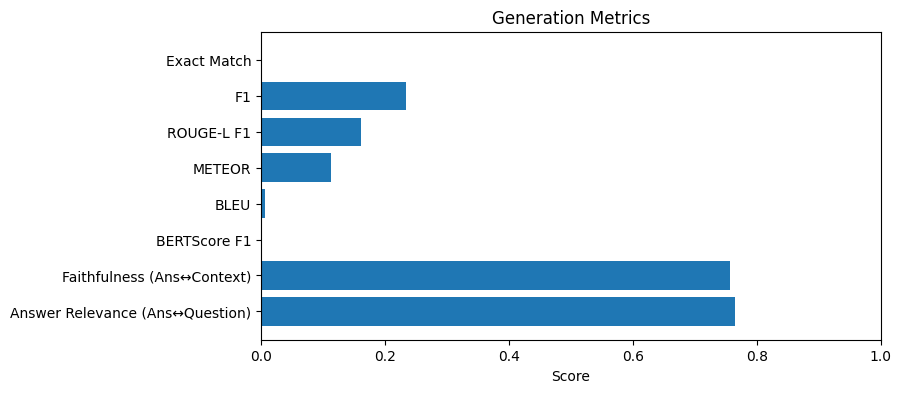

In [ ]:
# Step 16: Generation-Stage Evaluation Metrics (EM/F1, ROUGE-L, METEOR, BLEU, BERTScore, Faithfulness, Answer Relevance)

# If needed, install once:
# !pip -q install rouge-score nltk bert-score

import math, numpy as np, pandas as pd
from collections import OrderedDict
from rouge_score import rouge_scorer
import nltk

# Ensure NLTK resources (for METEOR)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Optional: BERTScore (set USE_BERTSCORE=True to compute)
USE_BERTSCORE = True
try:
    from bert_score import score as bertscore_score
except Exception:
    USE_BERTSCORE = False

# Helper: normalize and EM/F1 (SQuAD-style, token overlap)
import re
_ws = re.compile(r"\s+")
_punct = re.compile(r"[^a-z0-9 ]")
def normalize_text(s: str) -> str:
    s = s.lower().strip()
    s = _punct.sub(" ", s)
    s = _ws.sub(" ", s).strip()
    return s

def em_f1(pred: str, ref: str):
    p, r = normalize_text(pred), normalize_text(ref)
    em = 1.0 if p == r and p != "" else 0.0
    from collections import Counter
    ptoks, rtoks = p.split(), r.split()
    if not ptoks and not rtoks: return em, 1.0
    if not ptoks or not rtoks:  return em, 0.0
    pc, rc = Counter(ptoks), Counter(rtoks)
    overlap = sum((pc & rc).values())
    if overlap == 0: return em, 0.0
    prec = overlap / max(len(ptoks), 1)
    rec  = overlap / max(len(rtoks), 1)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    return em, f1

# Helper: cosine similarity in [0,1] after scaling
def cosine01(a: np.ndarray, b: np.ndarray) -> float:
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    cos = float(np.dot(a, b) / denom)
    return (cos + 1.0) / 2.0

# Prepare inputs
try:
    prediction = response
except NameError:
    raise NameError("Variable `response` not found. Run Step 13 to generate an answer first.")

# Provide your ground-truth reference answer here:
try:
    reference = ground_truth
except NameError:
    reference = """Some common policy conditions found in a Commercial General Liability policy may include but are not limited to:
    'Policy period: Specifies the effective dates of coverage under the policy.
    'Insuring agreement: Outlines the scope of coverage provided by the policy.
    'Duties in the event of occurrence, offense, claim, or suit: Describes the insured's obligations when an incident occurs that may lead to a claim.
    'Conditions for cancellation: Details the conditions under which the insurer or the insured can cancel the policy.
    'Subrogation: Explains the rights of the insurer to pursue recovery from third parties responsible for a loss covered by the policy.
    'Changes to the policy: Specifies how changes or amendments to the policy may be made.
    'Compliance with policy conditions: Requires the insured to meet all policy conditions to maintain coverage."""  # <-- edit this
try:
    qtext = query
except NameError:
    qtext = ""

# Faithfulness uses retrieved context; expects `top_reranked_docs` from Step 7
try:
    context_nodes = top_reranked_docs
except NameError:
    context_nodes = []

# Tokenize prediction and reference for metrics requiring tokenized input
prediction_tokens = prediction.split()
reference_tokens = reference.split()


# 1) EM & F1
EM, F1 = em_f1(prediction, reference)

# 2) ROUGE-L F1 (using rouge-score)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rougeL_f = rouge.score(reference, prediction)['rougeL'].fmeasure

# 3) METEOR (NLTK)
METEOR = meteor_score([reference_tokens], prediction_tokens)

# 4) BLEU (NLTK, smoothed)
BLEU = sentence_bleu([reference_tokens], prediction_tokens, smoothing_function=SmoothingFunction().method1)

# 5) BERTScore F1 (optional)
BERT_F1 = np.nan
if USE_BERTSCORE:
    try:
        _, _, F1s = bertscore_score([prediction], [reference], lang='en')
        BERT_F1 = float(F1s.mean().item())
    except Exception:
        BERT_F1 = np.nan

# 6) Faithfulness and Answer Relevance via embeddings
from langchain_huggingface import HuggingFaceEmbeddings
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
EVAL_EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # light & good default
embedder = HuggingFaceEmbeddings(
    model_name=EVAL_EMBEDDING_MODEL,
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True, "batch_size": 128},
)

# Answer vs Question relevance
if qtext:
    ans_vec = np.array(embedder.embed_query(prediction), dtype=np.float32)
    q_vec   = np.array(embedder.embed_query(qtext), dtype=np.float32)
    Answer_Relevance = cosine01(ans_vec, q_vec)
else:
    ans_vec = np.array(embedder.embed_query(prediction), dtype=np.float32)
    Answer_Relevance = np.nan

# Faithfulness: max similarity between answer and any retrieved context chunk
if context_nodes:
    ctx_texts = [d.page_content for d in context_nodes if getattr(d, "page_content", None)]
    if len(ctx_texts) > 0:
        ctx_vecs = np.array(embedder.embed_documents(ctx_texts), dtype=np.float32)
        sims = ctx_vecs @ ans_vec  # cosine (normalized)
        Faithfulness = float((sims.max() + 1.0) / 2.0)
    else:
        Faithfulness = np.nan
else:
    Faithfulness = np.nan

# Assemble results table
rows = [
    ("Exact Match", EM),
    ("F1", F1),
    ("ROUGE-L F1", rougeL_f),
    ("METEOR", METEOR),
    ("BLEU", BLEU),
    ("BERTScore F1", BERT_F1),
    ("Faithfulness (Ans↔Context)", Faithfulness),
    ("Answer Relevance (Ans↔Question)", Answer_Relevance),
]

df_gen_metrics = pd.DataFrame(rows, columns=["Metric", "Value"])

# Display table
from IPython.display import display
print("✅ Step 14 Complete: Generation-Stage Metrics")
display(df_gen_metrics)

# Optional: simple bar chart
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.barh(df_gen_metrics["Metric"], df_gen_metrics["Value"])
    plt.title("Generation Metrics")
    plt.xlabel("Score")
    plt.xlim(0, 1)
    plt.gca().invert_yaxis()
    plt.show()
except Exception as e:
    print("Plot skipped:", e)

In [ ]:
#Step 17: Response generation using GPT-3.5
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response_gpt3_5(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_reranked_docs}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_reranked_docs}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [ ]:
# Generate the response

import openai
from IPython.display import Markdown
from google.colab import userdata
import os

api_key = userdata.get("OPENAI_API_KEY")
if not api_key:
    raise RuntimeError("Add a secret named OPENAI_API_KEY in Colab first.")
os.environ["OPENAI_API_KEY"] = api_key


response = generate_response_gpt3_5(query, top_reranked_docs)
from IPython.display import Markdown

text = "\n".join(response)
display(Markdown(text))

The common policy conditions of the Commercial General Liability policy typically include standard provisions that set out the general rules and requirements of the policy. Some common policy conditions found in a Commercial General Liability policy may include but are not limited to:

1. Policy period: Specifies the effective dates of coverage under the policy.
2. Insuring agreement: Outlines the scope of coverage provided by the policy.
3. Duties in the event of occurrence, offense, claim, or suit: Describes the insured's obligations when an incident occurs that may lead to a claim.
4. Conditions for cancellation: Details the conditions under which the insurer or the insured can cancel the policy.
5. Subrogation: Explains the rights of the insurer to pursue recovery from third parties responsible for a loss covered by the policy.
6. Changes to the policy: Specifies how changes or amendments to the policy may be made.
7. Compliance with policy conditions: Requires the insured to meet all policy conditions to maintain coverage.

For specific details and additional conditions, please refer to the Commercial General Liability policy document at the following citations:

1. Policy Name: Commercial General Liability (CGL) Coverage Form
   Page Number: 57

2. Policy Name: Commercial General Liability (CGL) Coverage Form
   Page Number: 11

Feel free to refer to the above-mentioned policy documents to review the complete set of common policy conditions for the Commercial General Liability policy.